<ipython-input-3-dd8ab350cea8>:64: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('df.csv', index_col='Date', parse_dates=True)


Total Return: 138.48%
Annualized Return: 41.96%
Annualized Volatility: 13.08%
Sharpe Ratio: 2.75


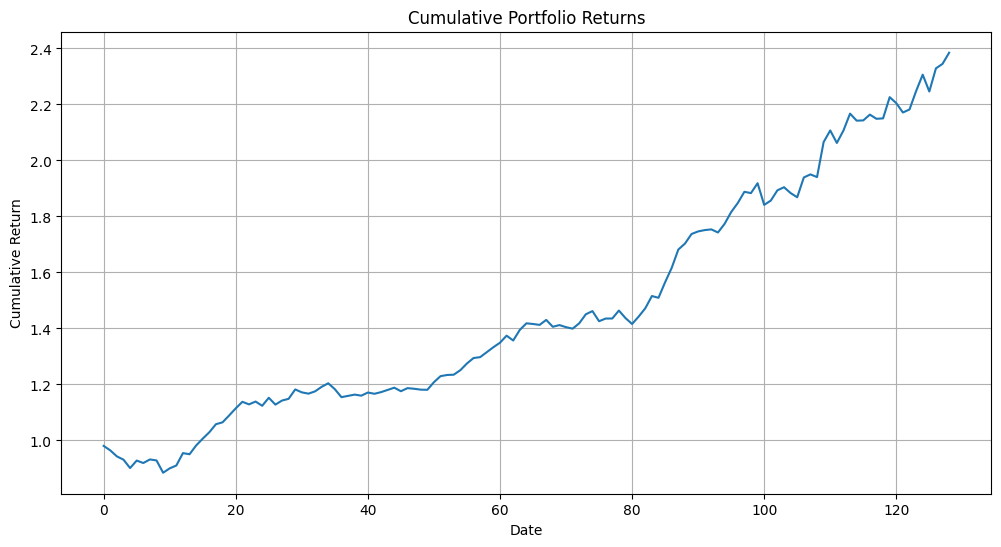

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

def calculate_weekly_returns(df):
    # Resample to weekly data and calculate returns
    weekly_data = df.resample('W').last()
    weekly_returns = weekly_data.pct_change().dropna()
    return weekly_returns

def rank_stocks(weekly_returns, window=50):
    # Calculate 50-week moving average of returns
    avg_returns = weekly_returns.rolling(window=window).mean()

    # Rank stocks based on the latest 50-week average return
    latest_avg_returns = avg_returns.iloc[-1].sort_values(ascending=False)
    return latest_avg_returns.index.tolist()

def get_top_stocks(ranked_stocks, n=15):
    return ranked_stocks[:n]

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def create_min_variance_portfolio(returns):
    n = len(returns.columns)

    # Initial guess of equal weights
    init_guess = np.array([1/n for _ in range(n)])

    # Constraints
    bounds = tuple((0, 1) for _ in range(n))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    # Minimize the portfolio variance
    result = minimize(portfolio_variance, init_guess, args=(returns.cov(),),
                      method='SLSQP', bounds=bounds, constraints=constraints)

    return result.x

def backtest_strategy(df, rebalance_period=1):
    weekly_returns = calculate_weekly_returns(df)
    portfolio_returns = []

    for i in range(50, len(weekly_returns), rebalance_period):
        # Get data up to current week
        data_slice = weekly_returns.iloc[:i]

        # Rank stocks and get top 15
        ranked_stocks = rank_stocks(data_slice)
        top_stocks = get_top_stocks(ranked_stocks)

        # Create minimum variance portfolio
        top_stock_returns = data_slice[top_stocks].iloc[-50:]  # Use last 50 weeks of data
        weights = create_min_variance_portfolio(top_stock_returns)

        # Calculate portfolio return for next week
        next_week_return = weekly_returns.iloc[i][top_stocks].dot(weights)
        portfolio_returns.append(next_week_return)

    return pd.Series(portfolio_returns)

# Load the data
df = pd.read_csv('df.csv', index_col='Date', parse_dates=True)

# Run the backtest
portfolio_returns = backtest_strategy(df)

# Calculate cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod()

# Print results
print(f"Total Return: {cumulative_returns.iloc[-1] - 1:.2%}")
print(f"Annualized Return: {(cumulative_returns.iloc[-1] ** (52/len(cumulative_returns)) - 1):.2%}")
print(f"Annualized Volatility: {portfolio_returns.std() * np.sqrt(52):.2%}")
print(f"Sharpe Ratio: {portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(52):.2f}")

# Plot cumulative returns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
cumulative_returns.plot()
plt.title('Cumulative Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

<ipython-input-7-e241595327f1>:38: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('df.csv', index_col='Date', parse_dates=True)


Error: Not enough historical data before the target date.

Backtest Results:
Total Return: 208.97%
Annualized Return: 57.57%
Annualized Volatility: 12.14%
Sharpe Ratio: 3.82


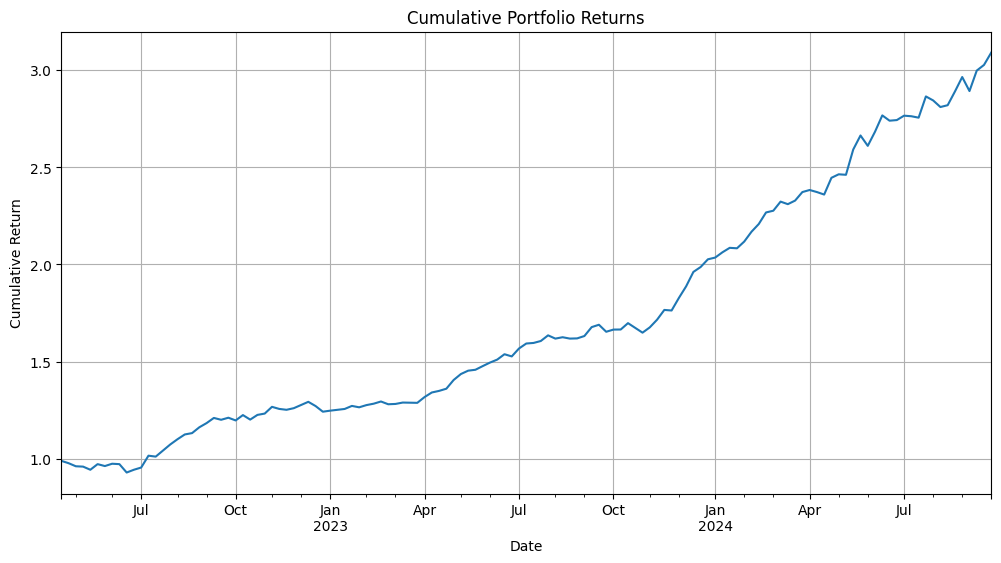

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# ... [Previous functions remain the same] ...

def get_nearest_date(index, target_date):
    return index[index.get_indexer([target_date], method='nearest')[0]]

def get_stock_weightage(df, target_date):
    weekly_returns = calculate_weekly_returns(df)

    # Find the nearest date to the target date
    nearest_date = get_nearest_date(weekly_returns.index, target_date)
    target_index = weekly_returns.index.get_loc(nearest_date)

    # Ensure we have at least 50 weeks of data before the target date
    if target_index < 50:
        raise ValueError("Not enough historical data before the target date.")

    # Get data up to target week
    data_slice = weekly_returns.iloc[:target_index+1]

    # Rank stocks and get top 15
    ranked_stocks = rank_stocks(data_slice)
    top_stocks = get_top_stocks(ranked_stocks)

    # Create minimum variance portfolio
    top_stock_returns = data_slice[top_stocks].iloc[-50:]  # Use last 50 weeks of data
    weights = create_min_variance_portfolio(top_stock_returns)

    # Create a dictionary of stock weights
    stock_weights = dict(zip(top_stocks, weights))

    return stock_weights, nearest_date

# Load the data
df = pd.read_csv('df.csv', index_col='Date', parse_dates=True)

# Example usage:
target_date = pd.Timestamp('2022-01-02')  # Replace with your desired date
try:
    weightage, actual_date = get_stock_weightage(df, target_date)
    print(f"Stock weightage for week of {actual_date.date()}:")
    for stock, weight in weightage.items():
        print(f"{stock}: {weight:.4f}")
except ValueError as e:
    print(f"Error: {e}")

# Updated backtesting function
def backtest_strategy(df, rebalance_period=1):
    weekly_returns = calculate_weekly_returns(df)
    portfolio_returns = []

    for i in range(50, len(weekly_returns), rebalance_period):
        current_date = weekly_returns.index[i]

        try:
            weightage, _ = get_stock_weightage(df, current_date)
            top_stocks = list(weightage.keys())
            weights = list(weightage.values())

            # Calculate portfolio return for next week
            next_week_return = weekly_returns.iloc[i][top_stocks].dot(weights)
            portfolio_returns.append(next_week_return)

        except ValueError:
            print(f"Skipping week {current_date} due to insufficient data")

    return pd.Series(portfolio_returns, index=weekly_returns.index[50::rebalance_period])

# Run the backtest
portfolio_returns = backtest_strategy(df)

# Calculate and print results
cumulative_returns = (1 + portfolio_returns).cumprod()
print(f"\nBacktest Results:")
print(f"Total Return: {cumulative_returns.iloc[-1] - 1:.2%}")
print(f"Annualized Return: {(cumulative_returns.iloc[-1] ** (52/len(cumulative_returns)) - 1):.2%}")
print(f"Annualized Volatility: {portfolio_returns.std() * np.sqrt(52):.2%}")
print(f"Sharpe Ratio: {portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(52):.2f}")

# Plot cumulative returns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
cumulative_returns.plot()
plt.title('Cumulative Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

<ipython-input-9-4d329e6d3026>:74: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('df.csv', index_col='Date', parse_dates=True)


Running backtest...

Backtest Results:
Total Return: 208.97%
Annualized Return: 57.57%
Annualized Volatility: 12.14%
Sharpe Ratio: 3.82


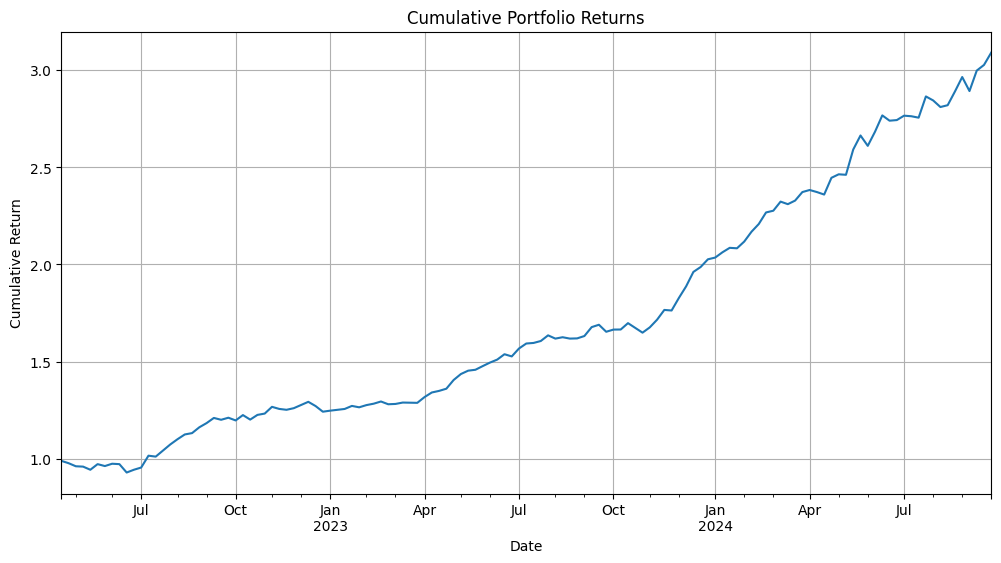

KeyboardInterrupt: Interrupted by user

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def calculate_weekly_returns(df):
    weekly_data = df.resample('W').last()
    weekly_returns = weekly_data.pct_change().dropna()
    return weekly_returns

def rank_stocks(weekly_returns, window=50):
    avg_returns = weekly_returns.rolling(window=window).mean()
    latest_avg_returns = avg_returns.iloc[-1].sort_values(ascending=False)
    return latest_avg_returns.index.tolist()

def get_top_stocks(ranked_stocks, n=15):
    return ranked_stocks[:n]

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def create_min_variance_portfolio(returns):
    n = len(returns.columns)
    init_guess = np.array([1/n for _ in range(n)])
    bounds = tuple((0, 1) for _ in range(n))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    result = minimize(portfolio_variance, init_guess, args=(returns.cov(),),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

def get_nearest_date(index, target_date):
    return index[index.get_indexer([target_date], method='nearest')[0]]

def get_stock_weightage(df, target_date):
    weekly_returns = calculate_weekly_returns(df)
    nearest_date = get_nearest_date(weekly_returns.index, target_date)
    target_index = weekly_returns.index.get_loc(nearest_date)

    if target_index < 50:
        raise ValueError("Not enough historical data before the target date.")

    data_slice = weekly_returns.iloc[:target_index+1]
    ranked_stocks = rank_stocks(data_slice)
    top_stocks = get_top_stocks(ranked_stocks)
    top_stock_returns = data_slice[top_stocks].iloc[-50:]
    weights = create_min_variance_portfolio(top_stock_returns)
    stock_weights = dict(zip(top_stocks, weights))

    return stock_weights, nearest_date

def backtest_strategy(df, rebalance_period=1):
    weekly_returns = calculate_weekly_returns(df)
    portfolio_returns = []
    weightage_history = []

    for i in range(50, len(weekly_returns), rebalance_period):
        current_date = weekly_returns.index[i]

        try:
            weightage, _ = get_stock_weightage(df, current_date)
            top_stocks = list(weightage.keys())
            weights = list(weightage.values())

            next_week_return = weekly_returns.iloc[i][top_stocks].dot(weights)
            portfolio_returns.append(next_week_return)
            weightage_history.append((current_date, weightage))

        except ValueError:
            print(f"Skipping week {current_date} due to insufficient data")

    return pd.Series(portfolio_returns, index=weekly_returns.index[50::rebalance_period]), weightage_history

# Load the data
df = pd.read_csv('df.csv', index_col='Date', parse_dates=True)

# Run the backtest
print("Running backtest...")
portfolio_returns, weightage_history = backtest_strategy(df)

# Calculate and print results
cumulative_returns = (1 + portfolio_returns).cumprod()
print("\nBacktest Results:")
print(f"Total Return: {cumulative_returns.iloc[-1] - 1:.2%}")
print(f"Annualized Return: {(cumulative_returns.iloc[-1] ** (52/len(cumulative_returns)) - 1):.2%}")
print(f"Annualized Volatility: {portfolio_returns.std() * np.sqrt(52):.2%}")
print(f"Sharpe Ratio: {portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(52):.2f}")

# Plot cumulative returns
plt.figure(figsize=(12, 6))
cumulative_returns.plot()
plt.title('Cumulative Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

# Function to query weightage for a specific date
def query_weightage(target_date):
    try:
        weightage, actual_date = get_stock_weightage(df, target_date)
        print(f"\nStock weightage for week of {actual_date.date()}:")
        for stock, weight in weightage.items():
            print(f"{stock}: {weight:.4f}")
    except ValueError as e:
        print(f"Error: {e}")

# Interactive loop for querying weightages
while True:
    user_input = input("\nEnter a date (YYYY-MM-DD) to get stock weightage (or 'q' to quit): ")
    if user_input.lower() == 'q':
        break
    try:
        query_date = pd.Timestamp(user_input)
        query_weightage(query_date)
    except ValueError:
        print("Invalid date format. Please use YYYY-MM-DD.")

print("Thank you for using the Stock Portfolio Strategy tool!")

<ipython-input-13-7b84859745c8>:74: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('df1.csv', index_col='Date', parse_dates=True)


Running backtest...

Backtest Results:
Total Return: 672.29%
Annualized Return: 65.50%
Annualized Volatility: 13.58%
Sharpe Ratio: 3.80


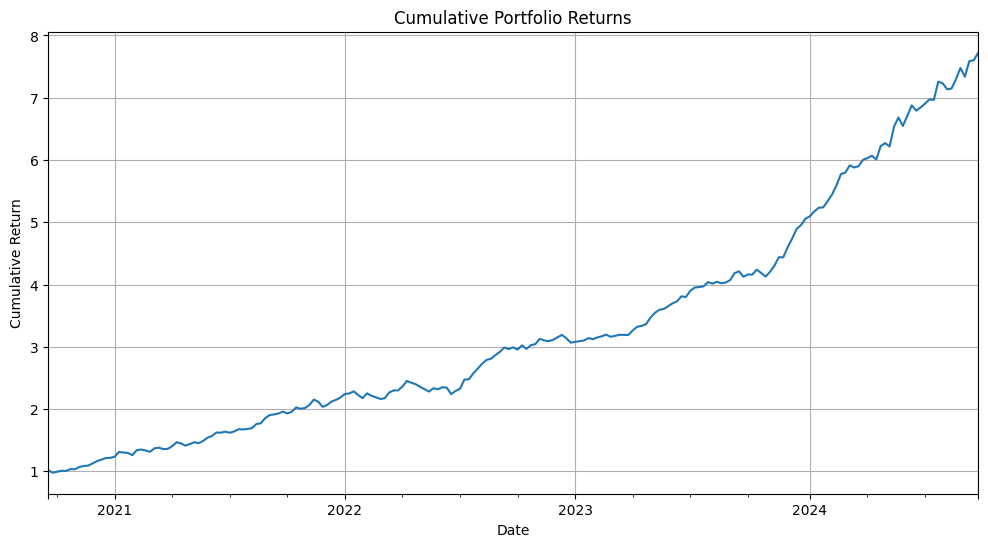


Stock weightage for week of 2022-10-02:
VBL: 0.0749
ABB: 0.0895
HAL: 0.0389
BEL: 0.0421
ITC: 0.0664
COALINDIA: 0.0577
SIEMENS: 0.0643
CIPLA: 0.1251
BHARTIARTL: 0.0994
VEDL: 0.0362
SUNPHARMA: 0.0924
PIDILITIND: 0.0734
ADANIENT: 0.0000
LT: 0.0491
HINDUNILVR: 0.0904


In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def calculate_weekly_returns(df):
    weekly_data = df.resample('W').last()
    weekly_returns = weekly_data.pct_change().dropna()
    return weekly_returns

def rank_stocks(weekly_returns, window=50):
    avg_returns = weekly_returns.rolling(window=window).mean()
    latest_avg_returns = avg_returns.iloc[-1].sort_values(ascending=False)
    return latest_avg_returns.index.tolist()

def get_top_stocks(ranked_stocks, n=15):
    return ranked_stocks[:n]

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def create_min_variance_portfolio(returns):
    n = len(returns.columns)
    init_guess = np.array([1/n for _ in range(n)])
    bounds = tuple((0, 1) for _ in range(n))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    result = minimize(portfolio_variance, init_guess, args=(returns.cov(),),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

def get_nearest_date(index, target_date):
    return index[index.get_indexer([target_date], method='nearest')[0]]

def get_stock_weightage(df, target_date):
    weekly_returns = calculate_weekly_returns(df)
    nearest_date = get_nearest_date(weekly_returns.index, target_date)
    target_index = weekly_returns.index.get_loc(nearest_date)

    if target_index < 50:
        raise ValueError("Not enough historical data before the target date.")

    data_slice = weekly_returns.iloc[:target_index+1]
    ranked_stocks = rank_stocks(data_slice)
    top_stocks = get_top_stocks(ranked_stocks)
    top_stock_returns = data_slice[top_stocks].iloc[-50:]
    weights = create_min_variance_portfolio(top_stock_returns)
    stock_weights = dict(zip(top_stocks, weights))

    return stock_weights, nearest_date

def backtest_strategy(df, rebalance_period=1):
    weekly_returns = calculate_weekly_returns(df)
    portfolio_returns = []
    weightage_history = []

    for i in range(50, len(weekly_returns), rebalance_period):
        current_date = weekly_returns.index[i]

        try:
            weightage, _ = get_stock_weightage(df, current_date)
            top_stocks = list(weightage.keys())
            weights = list(weightage.values())

            next_week_return = weekly_returns.iloc[i][top_stocks].dot(weights)
            portfolio_returns.append(next_week_return)
            weightage_history.append((current_date, weightage))

        except ValueError:
            print(f"Skipping week {current_date} due to insufficient data")

    return pd.Series(portfolio_returns, index=weekly_returns.index[50::rebalance_period]), weightage_history

# Load the data
df = pd.read_csv('df1.csv', index_col='Date', parse_dates=True)

# Run the backtest
print("Running backtest...")
portfolio_returns, weightage_history = backtest_strategy(df)

# Calculate and print results
cumulative_returns = (1 + portfolio_returns).cumprod()
print("\nBacktest Results:")
print(f"Total Return: {cumulative_returns.iloc[-1] - 1:.2%}")
print(f"Annualized Return: {(cumulative_returns.iloc[-1] ** (52/len(cumulative_returns)) - 1):.2%}")
print(f"Annualized Volatility: {portfolio_returns.std() * np.sqrt(52):.2%}")
print(f"Sharpe Ratio: {portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(52):.2f}")

# Plot cumulative returns
plt.figure(figsize=(12, 6))
cumulative_returns.plot()
plt.title('Cumulative Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

# Get weightage for specific date
specific_date = pd.Timestamp('2022-09-30')
try:
    weightage, actual_date = get_stock_weightage(df, specific_date)
    print(f"\nStock weightage for week of {actual_date.date()}:")
    for stock, weight in weightage.items():
        print(f"{stock}: {weight:.4f}")
except ValueError as e:
    print(f"Error: {e}")

<ipython-input-15-017136c72442>:9: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('df1.csv', index_col='Date', parse_dates=True)


Running backtest...

Backtest Results:
Total Return (including initial capital): 7.7229
This means for every $1 invested, you now have $7.72
Profit-only Return: 672.2931%
Annualized Return: 65.50%
Annualized Volatility: 13.58%
Sharpe Ratio: 3.80


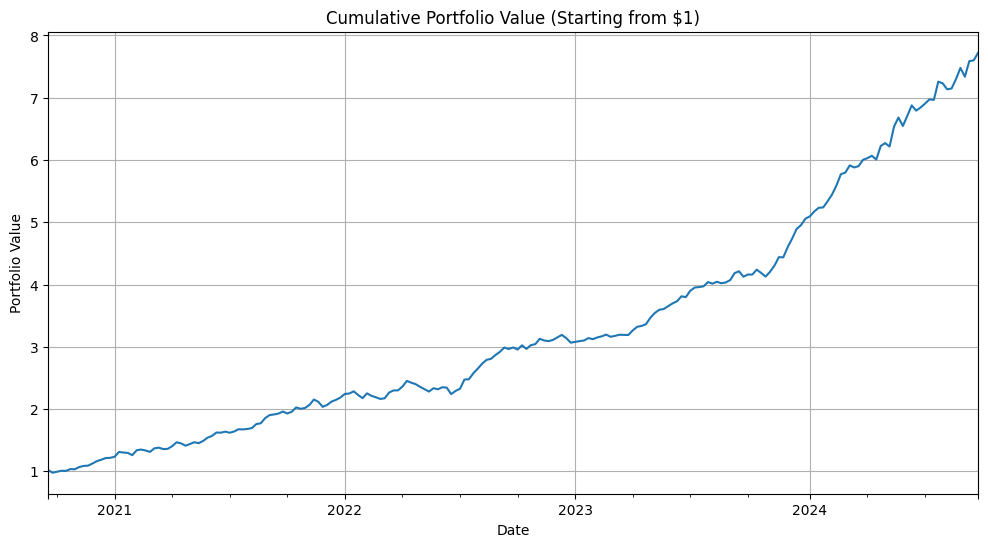


Stock weightage for week of 2022-10-02:
VBL: 0.0749
ABB: 0.0895
HAL: 0.0389
BEL: 0.0421
ITC: 0.0664
COALINDIA: 0.0577
SIEMENS: 0.0643
CIPLA: 0.1251
BHARTIARTL: 0.0994
VEDL: 0.0362
SUNPHARMA: 0.0924
PIDILITIND: 0.0734
ADANIENT: 0.0000
LT: 0.0491
HINDUNILVR: 0.0904


In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# ... [All previous functions remain the same] ...

# Load the data
df = pd.read_csv('df1.csv', index_col='Date', parse_dates=True)

# Run the backtest
print("Running backtest...")
portfolio_returns, weightage_history = backtest_strategy(df)

# Calculate and print results
cumulative_returns = (1 + portfolio_returns).cumprod()
total_return = cumulative_returns.iloc[-1]
profit_only_return = total_return - 1

print("\nBacktest Results:")
print(f"Total Return (including initial capital): {total_return:.4f}")
print(f"This means for every $1 invested, you now have ${total_return:.2f}")
print(f"Profit-only Return: {profit_only_return:.4%}")
print(f"Annualized Return: {(total_return ** (52/len(cumulative_returns)) - 1):.2%}")
print(f"Annualized Volatility: {portfolio_returns.std() * np.sqrt(52):.2%}")
print(f"Sharpe Ratio: {portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(52):.2f}")

# Plot cumulative returns
plt.figure(figsize=(12, 6))
cumulative_returns.plot()
plt.title('Cumulative Portfolio Value (Starting from $1)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()

# Get weightage for specific date
specific_date = pd.Timestamp('2022-09-30')
try:
    weightage, actual_date = get_stock_weightage(df, specific_date)
    print(f"\nStock weightage for week of {actual_date.date()}:")
    for stock, weight in weightage.items():
        print(f"{stock}: {weight:.4f}")
except ValueError as e:
    print(f"Error: {e}")

<ipython-input-17-bf34725ecb3d>:75: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('df1.csv', index_col='Date', parse_dates=True)


Running backtest...

Backtest Results:
Total Return (including initial capital): 3.8248
This means for every $1 invested, you now have $3.82
Profit-only Return: 282.4774%
Annualized Return: 39.40%
Annualized Volatility: 15.15%
Sharpe Ratio: 2.27


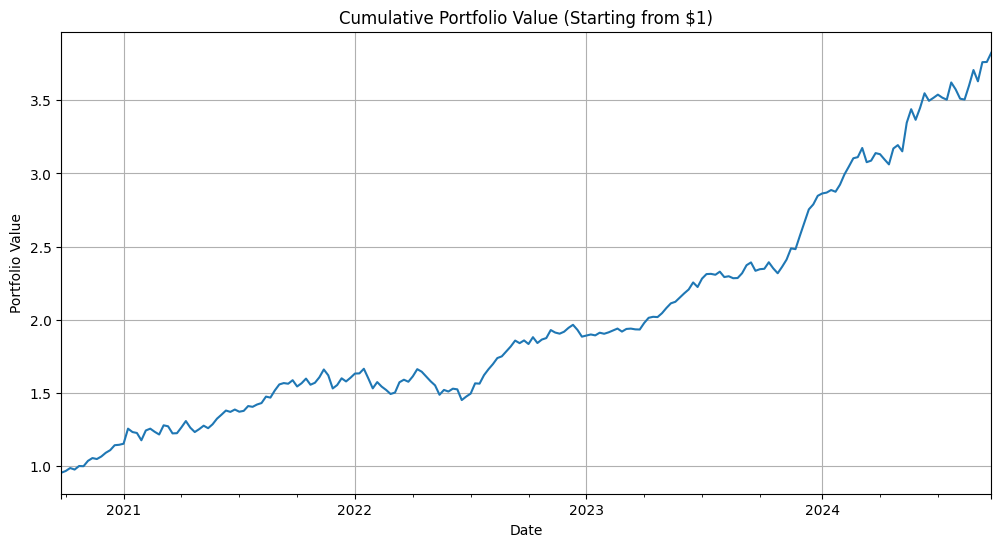


Stock weightage for week of 2022-10-02:
VBL: 0.0749
ABB: 0.0895
HAL: 0.0389
BEL: 0.0421
ITC: 0.0664
COALINDIA: 0.0577
SIEMENS: 0.0643
CIPLA: 0.1251
BHARTIARTL: 0.0994
VEDL: 0.0362
SUNPHARMA: 0.0924
PIDILITIND: 0.0734
ADANIENT: 0.0000
LT: 0.0491
HINDUNILVR: 0.0904


In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def calculate_weekly_returns(df):
    weekly_data = df.resample('W').last()
    weekly_returns = weekly_data.pct_change().dropna()
    return weekly_returns

def rank_stocks(weekly_returns, window=50):
    avg_returns = weekly_returns.rolling(window=window).mean()
    latest_avg_returns = avg_returns.iloc[-1].sort_values(ascending=False)
    return latest_avg_returns.index.tolist()

def get_top_stocks(ranked_stocks, n=15):
    return ranked_stocks[:n]

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def create_min_variance_portfolio(returns):
    n = len(returns.columns)
    init_guess = np.array([1/n for _ in range(n)])
    bounds = tuple((0, 1) for _ in range(n))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    result = minimize(portfolio_variance, init_guess, args=(returns.cov(),),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

def get_nearest_date(index, target_date):
    return index[index.get_indexer([target_date], method='nearest')[0]]

def get_stock_weightage(df, target_date):
    weekly_returns = calculate_weekly_returns(df)
    nearest_date = get_nearest_date(weekly_returns.index, target_date)
    target_index = weekly_returns.index.get_loc(nearest_date)

    if target_index < 50:
        raise ValueError("Not enough historical data before the target date.")

    data_slice = weekly_returns.iloc[:target_index+1]
    ranked_stocks = rank_stocks(data_slice)
    top_stocks = get_top_stocks(ranked_stocks)
    top_stock_returns = data_slice[top_stocks].iloc[-50:]
    weights = create_min_variance_portfolio(top_stock_returns)
    stock_weights = dict(zip(top_stocks, weights))

    return stock_weights, nearest_date

def backtest_strategy(df, rebalance_period=1):
    weekly_returns = calculate_weekly_returns(df)
    portfolio_returns = []
    weightage_history = []

    for i in range(50, len(weekly_returns) - 1, rebalance_period):
        current_date = weekly_returns.index[i]
        next_week = weekly_returns.index[i + 1]

        try:
            weightage, _ = get_stock_weightage(df.loc[:current_date], current_date)
            top_stocks = list(weightage.keys())
            weights = list(weightage.values())

            next_week_return = weekly_returns.loc[next_week][top_stocks].dot(weights)
            portfolio_returns.append(next_week_return)
            weightage_history.append((next_week, weightage))

        except ValueError:
            print(f"Skipping week {next_week} due to insufficient data")

    return pd.Series(portfolio_returns, index=weekly_returns.index[51::rebalance_period]), weightage_history

# Load the data
df = pd.read_csv('df1.csv', index_col='Date', parse_dates=True)

# Run the backtest
print("Running backtest...")
portfolio_returns, weightage_history = backtest_strategy(df)

# Calculate and print results
cumulative_returns = (1 + portfolio_returns).cumprod()
total_return = cumulative_returns.iloc[-1]
profit_only_return = total_return - 1

print("\nBacktest Results:")
print(f"Total Return (including initial capital): {total_return:.4f}")
print(f"This means for every $1 invested, you now have ${total_return:.2f}")
print(f"Profit-only Return: {profit_only_return:.4%}")
print(f"Annualized Return: {(total_return ** (52/len(cumulative_returns)) - 1):.2%}")
print(f"Annualized Volatility: {portfolio_returns.std() * np.sqrt(52):.2%}")
print(f"Sharpe Ratio: {portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(52):.2f}")

# Plot cumulative returns
plt.figure(figsize=(12, 6))
cumulative_returns.plot()
plt.title('Cumulative Portfolio Value (Starting from $1)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()

# Get weightage for specific date
specific_date = pd.Timestamp('2022-09-30')
try:
    weightage, actual_date = get_stock_weightage(df.loc[:specific_date], specific_date)
    print(f"\nStock weightage for week of {actual_date.date()}:")
    for stock, weight in weightage.items():
        print(f"{stock}: {weight:.4f}")
except ValueError as e:
    print(f"Error: {e}")

<ipython-input-18-963c42b2c1d8>:75: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('total_df.csv', index_col='Date', parse_dates=True)


Enter the number of weeks to consider for calculating average returns (e.g., 50): 50
Running backtest...

Backtest Results:
Total Return (including initial capital): 3.6565
This means for every $1 invested, you now have $3.66
Profit-only Return: 265.6504%
Annualized Return: 37.86%
Annualized Volatility: 16.61%
Sharpe Ratio: 2.02


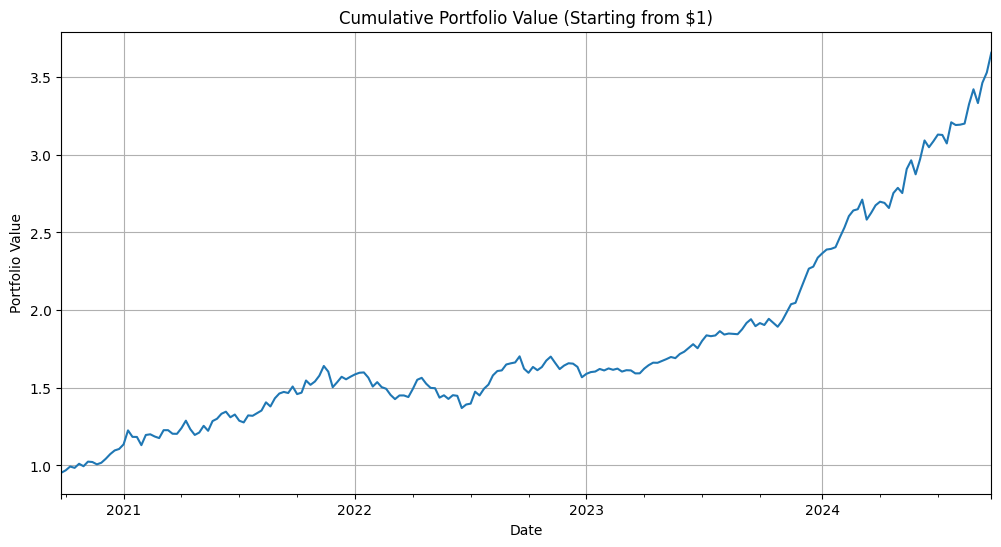


Stock weightage for week of 2022-10-02:
TATASTEEL: 0.0463
ADANIENT: 0.0000
ADANIGREEN: 0.0090
VBL: 0.0419
ABB: 0.1099
HAL: 0.0000
BEL: 0.0000
M&M: 0.0430
ITC: 0.0365
EICHERMOT: 0.0000
COALINDIA: 0.0505
TRENT: 0.0000
SIEMENS: 0.0287
CIPLA: 0.1828
MARUTI: 0.1186
ICICI: 0.0322
BHARTIARTL: 0.1081
VEDL: 0.0247
SUNPHARMA: 0.0986
NTPC: 0.0693


In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def calculate_weekly_returns(df):
    weekly_data = df.resample('W').last()
    weekly_returns = weekly_data.pct_change().dropna()
    return weekly_returns

def rank_stocks(weekly_returns, window):
    avg_returns = weekly_returns.rolling(window=window).mean()
    latest_avg_returns = avg_returns.iloc[-1].sort_values(ascending=False)
    return latest_avg_returns.index.tolist()

def get_top_stocks(ranked_stocks, n=20):
    return ranked_stocks[:n]

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def create_min_variance_portfolio(returns):
    n = len(returns.columns)
    init_guess = np.array([1/n for _ in range(n)])
    bounds = tuple((0, 1) for _ in range(n))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    result = minimize(portfolio_variance, init_guess, args=(returns.cov(),),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

def get_nearest_date(index, target_date):
    return index[index.get_indexer([target_date], method='nearest')[0]]

def get_stock_weightage(df, target_date, window):
    weekly_returns = calculate_weekly_returns(df)
    nearest_date = get_nearest_date(weekly_returns.index, target_date)
    target_index = weekly_returns.index.get_loc(nearest_date)

    if target_index < window:
        raise ValueError(f"Not enough historical data before the target date. Need at least {window} weeks of data.")

    data_slice = weekly_returns.iloc[:target_index+1]
    ranked_stocks = rank_stocks(data_slice, window)
    top_stocks = get_top_stocks(ranked_stocks)
    top_stock_returns = data_slice[top_stocks].iloc[-window:]
    weights = create_min_variance_portfolio(top_stock_returns)
    stock_weights = dict(zip(top_stocks, weights))

    return stock_weights, nearest_date

def backtest_strategy(df, window, rebalance_period=1):
    weekly_returns = calculate_weekly_returns(df)
    portfolio_returns = []
    weightage_history = []

    for i in range(window, len(weekly_returns) - 1, rebalance_period):
        current_date = weekly_returns.index[i]
        next_week = weekly_returns.index[i + 1]

        try:
            weightage, _ = get_stock_weightage(df.loc[:current_date], current_date, window)
            top_stocks = list(weightage.keys())
            weights = list(weightage.values())

            next_week_return = weekly_returns.loc[next_week][top_stocks].dot(weights)
            portfolio_returns.append(next_week_return)
            weightage_history.append((next_week, weightage))

        except ValueError:
            print(f"Skipping week {next_week} due to insufficient data")

    return pd.Series(portfolio_returns, index=weekly_returns.index[window+1::rebalance_period]), weightage_history

# Load the data
df = pd.read_csv('total_df.csv', index_col='Date', parse_dates=True)

# Get user input for window size
window = int(input("Enter the number of weeks to consider for calculating average returns (e.g., 50): "))

# Run the backtest
print("Running backtest...")
portfolio_returns, weightage_history = backtest_strategy(df, window)

# Calculate and print results
cumulative_returns = (1 + portfolio_returns).cumprod()
total_return = cumulative_returns.iloc[-1]
profit_only_return = total_return - 1

print("\nBacktest Results:")
print(f"Total Return (including initial capital): {total_return:.4f}")
print(f"This means for every $1 invested, you now have ${total_return:.2f}")
print(f"Profit-only Return: {profit_only_return:.4%}")
print(f"Annualized Return: {(total_return ** (52/len(cumulative_returns)) - 1):.2%}")
print(f"Annualized Volatility: {portfolio_returns.std() * np.sqrt(52):.2%}")
print(f"Sharpe Ratio: {portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(52):.2f}")

# Plot cumulative returns
plt.figure(figsize=(12, 6))
cumulative_returns.plot()
plt.title('Cumulative Portfolio Value (Starting from $1)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()

# Get weightage for specific date
specific_date = pd.Timestamp('2022-09-30')
try:
    weightage, actual_date = get_stock_weightage(df.loc[:specific_date], specific_date, window)
    print(f"\nStock weightage for week of {actual_date.date()}:")
    for stock, weight in weightage.items():
        print(f"{stock}: {weight:.4f}")
except ValueError as e:
    print(f"Error: {e}")

In [ ]:
# Get weightage for specific date
specific_date = pd.Timestamp('2022-10-10')
try:
    weightage, actual_date = get_stock_weightage(df.loc[:specific_date], specific_date, window)
    print(f"\nStock weightage for week of {actual_date.date()}:")
    for stock, weight in weightage.items():
        print(f"{stock}: {weight:.4f}")
except ValueError as e:
    print(f"Error: {e}")


Stock weightage for week of 2022-10-09:
TATASTEEL: 0.0498
ADANIENT: 0.0000
VBL: 0.0470
ADANIGREEN: 0.0161
HAL: 0.0000
ABB: 0.0932
BEL: 0.0000
COALINDIA: 0.0487
ITC: 0.0540
M&M: 0.0504
TRENT: 0.0000
EICHERMOT: 0.0152
SIEMENS: 0.0311
VEDL: 0.0258
CIPLA: 0.2214
MARUTI: 0.1149
NTPC: 0.0844
SUNPHARMA: 0.1105
ICICI: 0.0000
PIDILITIND: 0.0375


<ipython-input-26-d247c123d4a8>:72: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('total_df.csv', index_col='Date', parse_dates=True)


Running backtest...

Backtest Results:
Total Return (including initial capital): 3.7461
This means for every $1 invested, you now have $3.75
Profit-only Return: 274.6051%
Annualized Return: 38.47%
Annualized Volatility: 16.60%
Sharpe Ratio: 2.05


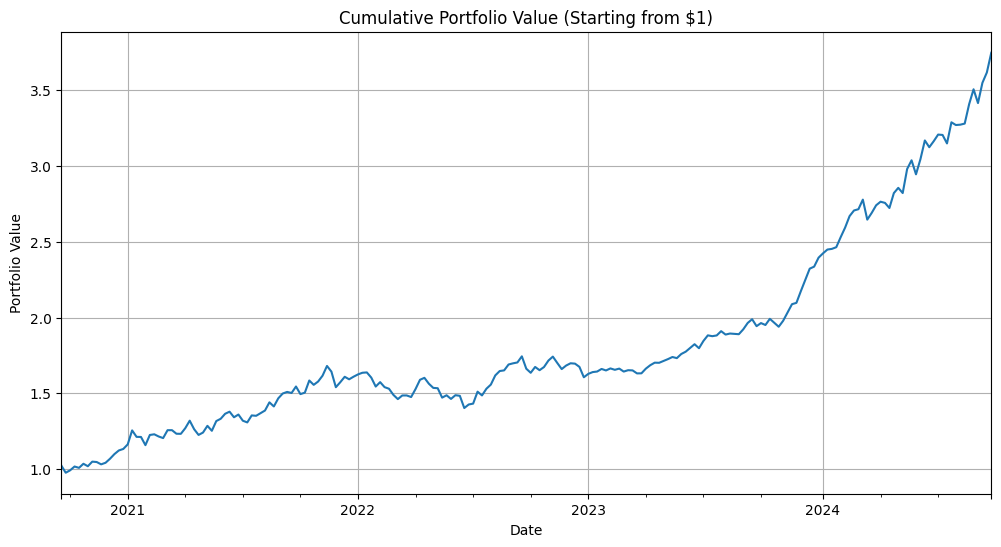


Stock weightage for week of 2024-09-26:
TRENT: 0.0962
BAJAJAUTO: 0.1213
HAL: 0.0000
VEDL: 0.0439
ADANIGREEN: 0.0060
BEL: 0.0013
SIEMENS: 0.0302
INDIGO: 0.0731
HINDZINC: 0.0058
ABB: 0.0000
NTPC: 0.0504
M&M: 0.0355
COALINDIA: 0.0086
BHARTIARTL: 0.1953
VBL: 0.0516
powergrid: 0.0557
ADANIENT.1: 0.0108
ONGC: 0.0883
SUNPHARMA: 0.1259
DLF: 0.0000


In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def calculate_weekly_returns(df):
    weekly_data = df.resample('W').last()
    weekly_returns = weekly_data.pct_change().dropna()
    return weekly_returns

def rank_stocks(weekly_returns, window=50):
    avg_returns = weekly_returns.rolling(window=window).mean()
    latest_avg_returns = avg_returns.iloc[-1].sort_values(ascending=False)
    return latest_avg_returns.index.tolist()

def get_top_stocks(ranked_stocks, n=20):
    return ranked_stocks[:n]

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def create_min_variance_portfolio(returns):
    n = len(returns.columns)
    init_guess = np.array([1/n for _ in range(n)])
    bounds = tuple((0, 1) for _ in range(n))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    result = minimize(portfolio_variance, init_guess, args=(returns.cov(),),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

def get_stock_weightage(weekly_returns, current_date):
    data_slice = weekly_returns.loc[:current_date].iloc[-50:]

    if len(data_slice) < 50:
        raise ValueError("Not enough historical data before the target date.")

    ranked_stocks = rank_stocks(data_slice)
    top_stocks = get_top_stocks(ranked_stocks)
    top_stock_returns = data_slice[top_stocks]
    weights = create_min_variance_portfolio(top_stock_returns)
    stock_weights = dict(zip(top_stocks, weights))

    return stock_weights

def backtest_strategy(df):
    weekly_returns = calculate_weekly_returns(df)
    portfolio_returns = []
    weightage_history = []

    for i in range(50, len(weekly_returns)):
        current_date = weekly_returns.index[i-1]
        next_week = weekly_returns.index[i]

        try:
            weightage = get_stock_weightage(weekly_returns.iloc[:i], current_date)
            top_stocks = list(weightage.keys())
            weights = list(weightage.values())

            next_week_return = weekly_returns.loc[next_week][top_stocks].dot(weights)
            portfolio_returns.append(next_week_return)
            weightage_history.append((next_week, weightage))

        except ValueError:
            print(f"Skipping week {next_week} due to insufficient data")

    # Adjust to make sure the length of portfolio_returns and index match
    valid_index = weekly_returns.index[50:50+len(portfolio_returns)]

    return pd.Series(portfolio_returns, index=valid_index), weightage_history

# Load the data
df = pd.read_csv('total_df.csv', index_col='Date', parse_dates=True)

# Run the backtest
print("Running backtest...")
portfolio_returns, weightage_history = backtest_strategy(df)

# Calculate and print results
cumulative_returns = (1 + portfolio_returns).cumprod()
total_return = cumulative_returns.iloc[-1]
profit_only_return = total_return - 1

print("\nBacktest Results:")
print(f"Total Return (including initial capital): {total_return:.4f}")
print(f"This means for every $1 invested, you now have ${total_return:.2f}")
print(f"Profit-only Return: {profit_only_return:.4%}")
print(f"Annualized Return: {(total_return ** (52/len(cumulative_returns)) - 1):.2%}")
print(f"Annualized Volatility: {portfolio_returns.std() * np.sqrt(52):.2%}")
print(f"Sharpe Ratio: {portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(52):.2f}")

# Plot cumulative returns
plt.figure(figsize=(12, 6))
cumulative_returns.plot()
plt.title('Cumulative Portfolio Value (Starting from $1)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()

# Get weightage for the last date in the dataset
last_date = df.index[-1]
try:
    weightage = get_stock_weightage(calculate_weekly_returns(df), last_date)
    print(f"\nStock weightage for week of {last_date.date()}:")
    for stock, weight in weightage.items():
        print(f"{stock}: {weight:.4f}")
except ValueError as e:
    print(f"Error: {e}")

<ipython-input-27-22dcef60f0fd>:86: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('total_df.csv', index_col='Date', parse_dates=True)


Running backtest...

Backtest Results:
Total Return (including initial capital): 3.7461
This means for every $1 invested, you now have $3.75
Profit-only Return: 274.6051%
Annualized Return: 38.47%
Annualized Volatility: 16.60%
Sharpe Ratio: 2.05


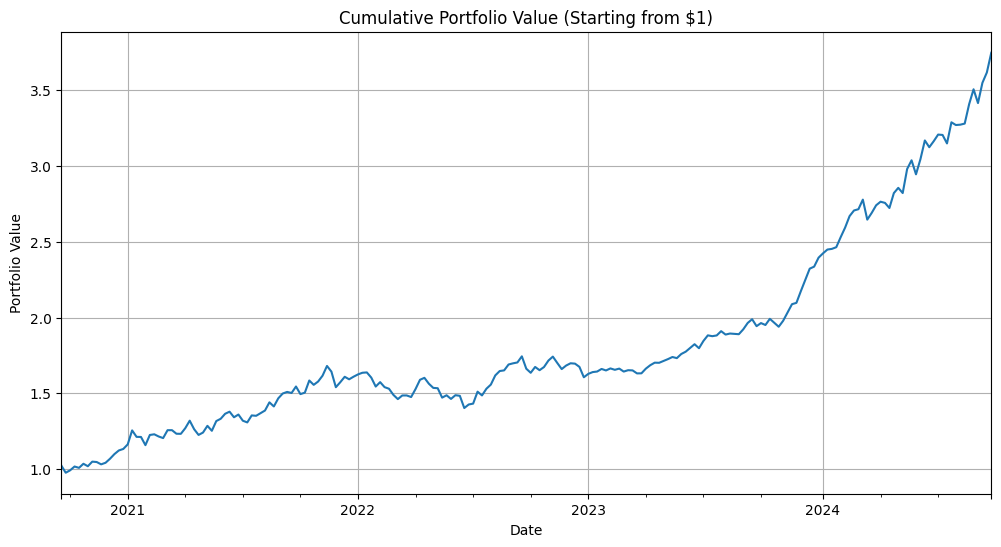


Stock weightage for week of 2024-09-29:
TRENT: 0.0933
VEDL: 0.0326
BAJAJAUTO: 0.1158
ADANIGREEN: 0.0047
HAL: 0.0000
BEL: 0.0069
SIEMENS: 0.0317
M&M: 0.0278
ABB: 0.0000
HINDZINC: 0.0082
powergrid: 0.0498
INDIGO: 0.0805
NTPC: 0.0544
ADANIENT.1: 0.0132
BHARTIARTL: 0.1901
COALINDIA: 0.0136
VBL: 0.0641
ONGC: 0.0879
DLF: 0.0000
SUNPHARMA: 0.1255


In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Calculate weekly returns by resampling the data weekly and using percent change
def calculate_weekly_returns(df):
    weekly_data = df.resample('W').last()
    weekly_returns = weekly_data.pct_change().dropna()
    return weekly_returns

# Rank stocks based on rolling average returns over a given window
def rank_stocks(weekly_returns, window=50):
    avg_returns = weekly_returns.rolling(window=window).mean().dropna()
    latest_avg_returns = avg_returns.iloc[-1].sort_values(ascending=False)
    return latest_avg_returns.index.tolist()

# Get the top N ranked stocks
def get_top_stocks(ranked_stocks, n=20):
    return ranked_stocks[:n]

# Calculate the portfolio variance given weights and the covariance matrix
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Optimize for the minimum variance portfolio given stock returns
def create_min_variance_portfolio(returns):
    n = len(returns.columns)
    init_guess = np.array([1/n for _ in range(n)])
    bounds = tuple((0, 1) for _ in range(n))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    result = minimize(portfolio_variance, init_guess, args=(returns.cov(),),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Calculate stock weightage for the portfolio at a given date
def get_stock_weightage(weekly_returns, current_date):
    data_slice = weekly_returns.loc[:current_date].iloc[-50:]

    if len(data_slice) < 50:
        raise ValueError("Not enough historical data before the target date.")

    ranked_stocks = rank_stocks(data_slice)
    top_stocks = get_top_stocks(ranked_stocks)
    top_stock_returns = data_slice[top_stocks]

    weights = create_min_variance_portfolio(top_stock_returns)
    stock_weights = dict(zip(top_stocks, weights))

    return stock_weights

# Backtesting function to calculate portfolio returns and store weight history
def backtest_strategy(df):
    weekly_returns = calculate_weekly_returns(df)
    portfolio_returns = []
    weightage_history = []

    for i in range(50, len(weekly_returns)):
        current_date = weekly_returns.index[i-1]
        next_week = weekly_returns.index[i]

        try:
            weightage = get_stock_weightage(weekly_returns.iloc[:i], current_date)
            top_stocks = list(weightage.keys())
            weights = list(weightage.values())

            # Ensure that only common stocks are considered
            common_stocks = weekly_returns.loc[next_week].index.intersection(top_stocks)
            next_week_return = weekly_returns.loc[next_week][common_stocks].dot(
                [weights[top_stocks.index(stock)] for stock in common_stocks]
            )

            portfolio_returns.append(next_week_return)
            weightage_history.append((next_week, weightage))

        except ValueError:
            print(f"Skipping week {next_week} due to insufficient data")

    # Create a valid index and return results
    valid_index = weekly_returns.index[50:]
    portfolio_returns_series = pd.Series(portfolio_returns, index=valid_index[:len(portfolio_returns)])

    return portfolio_returns_series, weightage_history

# Load the data
df = pd.read_csv('total_df.csv', index_col='Date', parse_dates=True)

# Run the backtest
print("Running backtest...")
portfolio_returns, weightage_history = backtest_strategy(df)

# Calculate and print backtest results
cumulative_returns = (1 + portfolio_returns).cumprod()
total_return = cumulative_returns.iloc[-1]
profit_only_return = total_return - 1

print("\nBacktest Results:")
print(f"Total Return (including initial capital): {total_return:.4f}")
print(f"This means for every $1 invested, you now have ${total_return:.2f}")
print(f"Profit-only Return: {profit_only_return:.4%}")
print(f"Annualized Return: {(total_return ** (52/len(cumulative_returns)) - 1):.2%}")
print(f"Annualized Volatility: {portfolio_returns.std() * np.sqrt(52):.2%}")
print(f"Sharpe Ratio: {portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(52):.2f}")

# Plot cumulative returns
plt.figure(figsize=(12, 6))
cumulative_returns.plot()
plt.title('Cumulative Portfolio Value (Starting from $1)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()

# Get weightage for the last date in the dataset
last_date = calculate_weekly_returns(df).index[-1]
try:
    weightage = get_stock_weightage(calculate_weekly_returns(df), last_date)
    print(f"\nStock weightage for week of {last_date.date()}:")
    for stock, weight in weightage.items():
        print(f"{stock}: {weight:.4f}")
except ValueError as e:
    print(f"Error: {e}")


Base Portfolio Final Code-


<ipython-input-28-7478e589972c>:86: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('total_df.csv', index_col='Date', parse_dates=True)


Running backtest...

Backtest Results:
Total Return (including initial capital): 3.7461
This means for every $1 invested, you now have $3.75
Profit-only Return: 274.6051%
Annualized Return: 38.47%
Annualized Volatility: 16.60%
Sharpe Ratio: 2.05
Sortino Ratio: 2.07
Max Drawdown: -16.51%
Calmar Ratio: 2.33


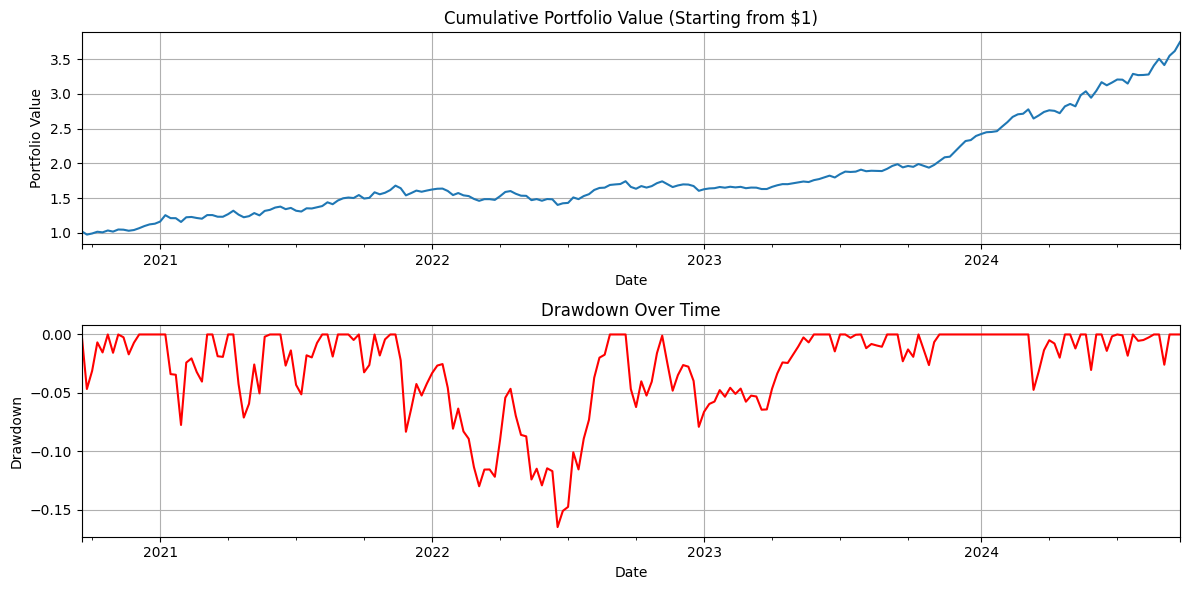


Stock weightage for week of 2024-09-26:
TRENT: 0.0962
BAJAJAUTO: 0.1213
HAL: 0.0000
VEDL: 0.0439
ADANIGREEN: 0.0060
BEL: 0.0013
SIEMENS: 0.0302
INDIGO: 0.0731
HINDZINC: 0.0058
ABB: 0.0000
NTPC: 0.0504
M&M: 0.0355
COALINDIA: 0.0086
BHARTIARTL: 0.1953
VBL: 0.0516
powergrid: 0.0557
ADANIENT.1: 0.0108
ONGC: 0.0883
SUNPHARMA: 0.1259
DLF: 0.0000


In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def calculate_weekly_returns(df):
    weekly_data = df.resample('W').last()
    weekly_returns = weekly_data.pct_change().dropna()
    return weekly_returns

def rank_stocks(weekly_returns, window=50):
    avg_returns = weekly_returns.rolling(window=window).mean()
    latest_avg_returns = avg_returns.iloc[-1].sort_values(ascending=False)
    return latest_avg_returns.index.tolist()

def get_top_stocks(ranked_stocks, n=20):
    return ranked_stocks[:n]

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def create_min_variance_portfolio(returns):
    n = len(returns.columns)
    init_guess = np.array([1/n for _ in range(n)])
    bounds = tuple((0, 1) for _ in range(n))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    result = minimize(portfolio_variance, init_guess, args=(returns.cov(),),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

def get_stock_weightage(weekly_returns, current_date):
    data_slice = weekly_returns.loc[:current_date].iloc[-50:]

    if len(data_slice) < 50:
        raise ValueError("Not enough historical data before the target date.")

    ranked_stocks = rank_stocks(data_slice)
    top_stocks = get_top_stocks(ranked_stocks)
    top_stock_returns = data_slice[top_stocks]
    weights = create_min_variance_portfolio(top_stock_returns)
    stock_weights = dict(zip(top_stocks, weights))

    return stock_weights

def calculate_drawdown(cumulative_returns):
    drawdown = cumulative_returns / cumulative_returns.cummax() - 1
    max_drawdown = drawdown.min()
    return drawdown, max_drawdown

def sortino_ratio(returns, target=0, periods_per_year=52):
    downside_returns = returns[returns < target]
    downside_deviation = np.sqrt((downside_returns ** 2).mean()) * np.sqrt(periods_per_year)
    annualized_return = returns.mean() * periods_per_year
    return annualized_return / downside_deviation if downside_deviation != 0 else np.nan

def calmar_ratio(annualized_return, max_drawdown):
    return annualized_return / abs(max_drawdown) if max_drawdown != 0 else np.nan

def backtest_strategy(df):
    weekly_returns = calculate_weekly_returns(df)
    portfolio_returns = []
    weightage_history = []

    for i in range(50, len(weekly_returns)):
        current_date = weekly_returns.index[i-1]
        next_week = weekly_returns.index[i]

        try:
            weightage = get_stock_weightage(weekly_returns.iloc[:i], current_date)
            top_stocks = list(weightage.keys())
            weights = list(weightage.values())

            next_week_return = weekly_returns.loc[next_week][top_stocks].dot(weights)
            portfolio_returns.append(next_week_return)
            weightage_history.append((next_week, weightage))

        except ValueError:
            print(f"Skipping week {next_week} due to insufficient data")

    # Adjust to make sure the length of portfolio_returns and index match
    valid_index = weekly_returns.index[50:50+len(portfolio_returns)]

    return pd.Series(portfolio_returns, index=valid_index), weightage_history

# Load the data
df = pd.read_csv('total_df.csv', index_col='Date', parse_dates=True)

# Run the backtest
print("Running backtest...")
portfolio_returns, weightage_history = backtest_strategy(df)

# Calculate cumulative returns and metrics
cumulative_returns = (1 + portfolio_returns).cumprod()
total_return = cumulative_returns.iloc[-1]
profit_only_return = total_return - 1
annualized_return = (total_return ** (52/len(cumulative_returns)) - 1)
annualized_volatility = portfolio_returns.std() * np.sqrt(52)
sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(52)

# Calculate drawdown and additional metrics
drawdown, max_drawdown = calculate_drawdown(cumulative_returns)
calmar = calmar_ratio(annualized_return, max_drawdown)
sortino = sortino_ratio(portfolio_returns)

# Print backtest results
print("\nBacktest Results:")
print(f"Total Return (including initial capital): {total_return:.4f}")
print(f"This means for every $1 invested, you now have ${total_return:.2f}")
print(f"Profit-only Return: {profit_only_return:.4%}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar:.2f}")

# Plot cumulative returns and drawdown
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
cumulative_returns.plot()
plt.title('Cumulative Portfolio Value (Starting from $1)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)

plt.subplot(2, 1, 2)
drawdown.plot(color='red')
plt.title('Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)

plt.tight_layout()
plt.show()

# Get weightage for the last date in the dataset
last_date = df.index[-1]
try:
    weightage = get_stock_weightage(calculate_weekly_returns(df), last_date)
    print(f"\nStock weightage for week of {last_date.date()}:")
    for stock, weight in weightage.items():
        print(f"{stock}: {weight:.4f}")
except ValueError as e:
    print(f"Error: {e}")


Applying Section-3 on base **portfolio**

In [ ]:
import numpy as np
import cvxopt
from cvxopt import matrix, solvers

def minimum_variance_portfolio(covariance_matrix, initial_weights=None, lambda_cost=0.005):
    """
    Implements minimum variance portfolio optimization with L1 regularization for transaction costs.

    Args:
        covariance_matrix (np.ndarray): N x N covariance matrix of asset returns
        initial_weights (np.ndarray, optional): Initial portfolio weights. If None, assumes equal weights
        lambda_cost (float): Transaction cost parameter (default 50 basis points = 0.005)

    Returns:
        np.ndarray: Optimized portfolio weights
    """
    n = len(covariance_matrix)

    # If no initial weights provided, assume equal weights
    if initial_weights is None:
        initial_weights = np.ones(n) / n

    # Convert numpy arrays to cvxopt matrices
    P = matrix(covariance_matrix)
    q = matrix(np.zeros(n))

    # Equality constraint (sum of weights = 1)
    A = matrix(np.ones((1, n)))
    b = matrix(np.ones(1))

    # L1 regularization for transaction costs
    # We need to reformulate the L1 norm using additional variables
    # |w - w0| ≤ u, where u is auxiliary variable
    G = matrix(np.vstack([
        np.eye(n),      # w - w0 ≤ u
        -np.eye(n),     # -w + w0 ≤ u
        -np.eye(n)      # w ≥ 0 (non-negative constraint)
    ]))

    h = matrix(np.hstack([
        initial_weights + 1,  # upper bound for u
        -initial_weights + 1, # upper bound for u
        np.zeros(n)          # non-negative constraint
    ]))

    # Solve the quadratic programming problem
    solvers.options['show_progress'] = False
    solution = solvers.qp(P, q, G, h, A, b)

    if solution['status'] != 'optimal':
        raise ValueError("Optimization failed to converge")

    # Extract the optimal weights
    weights = np.array(solution['x']).flatten()

    return weights

def update_portfolio_optimization(weekly_returns, current_date, previous_weights=None):
    """
    Updates portfolio weights using minimum variance optimization with transaction costs.

    Args:
        weekly_returns (pd.DataFrame): Historical weekly returns
        current_date: Current date for the optimization
        previous_weights (dict, optional): Previous portfolio weights

    Returns:
        dict: Updated portfolio weights
    """
    # Get recent data for optimization
    data_slice = weekly_returns.loc[:current_date].iloc[-50:]

    if len(data_slice) < 50:
        raise ValueError("Not enough historical data before the target date.")

    # Get top stocks based on historical performance
    ranked_stocks = rank_stocks(data_slice)
    top_stocks = get_top_stocks(ranked_stocks)
    top_stock_returns = data_slice[top_stocks]

    # Calculate covariance matrix
    cov_matrix = top_stock_returns.cov().values

    # Prepare initial weights
    if previous_weights is None:
        initial_weights = None
    else:
        initial_weights = np.array([previous_weights.get(stock, 0) for stock in top_stocks])

    # Optimize portfolio
    try:
        weights = minimum_variance_portfolio(cov_matrix, initial_weights)
        return dict(zip(top_stocks, weights))
    except ValueError as e:
        print(f"Optimization failed: {e}")
        # Fallback to equal weights if optimization fails
        return dict(zip(top_stocks, [1/len(top_stocks)] * len(top_stocks)))

def backtest_min_variance_strategy(df):
    """
    Backtests the minimum variance strategy with transaction costs.

    Args:
        df (pd.DataFrame): Price data

    Returns:
        tuple: (portfolio_returns, weightage_history)
    """
    weekly_returns = calculate_weekly_returns(df)
    portfolio_returns = []
    weightage_history = []
    previous_weights = None

    for i in range(50, len(weekly_returns)):
        current_date = weekly_returns.index[i-1]
        next_week = weekly_returns.index[i]

        try:
            # Get optimal weights considering transaction costs
            weightage = update_portfolio_optimization(
                weekly_returns.iloc[:i],
                current_date,
                previous_weights
            )

            # Calculate next week's return
            top_stocks = list(weightage.keys())
            weights = list(weightage.values())
            next_week_return = weekly_returns.loc[next_week][top_stocks].dot(weights)

            portfolio_returns.append(next_week_return)
            weightage_history.append((next_week, weightage))

            # Update previous weights for next iteration
            previous_weights = weightage

        except ValueError as e:
            print(f"Skipping week {next_week} due to: {e}")

    valid_index = weekly_returns.index[50:50+len(portfolio_returns)]
    return pd.Series(portfolio_returns, index=valid_index), weightage_history

Running backtest with minimum variance optimization...

Backtest Results:
Total Return (including initial capital): 3.4745
This means for every $1 invested, you now have $3.47
Profit-only Return: 247.4516%
Annualized Return: 35.93%
Annualized Volatility: 16.51%
Sharpe Ratio: 1.95
Sortino Ratio: 1.99
Max Drawdown: -13.88%
Calmar Ratio: 2.59


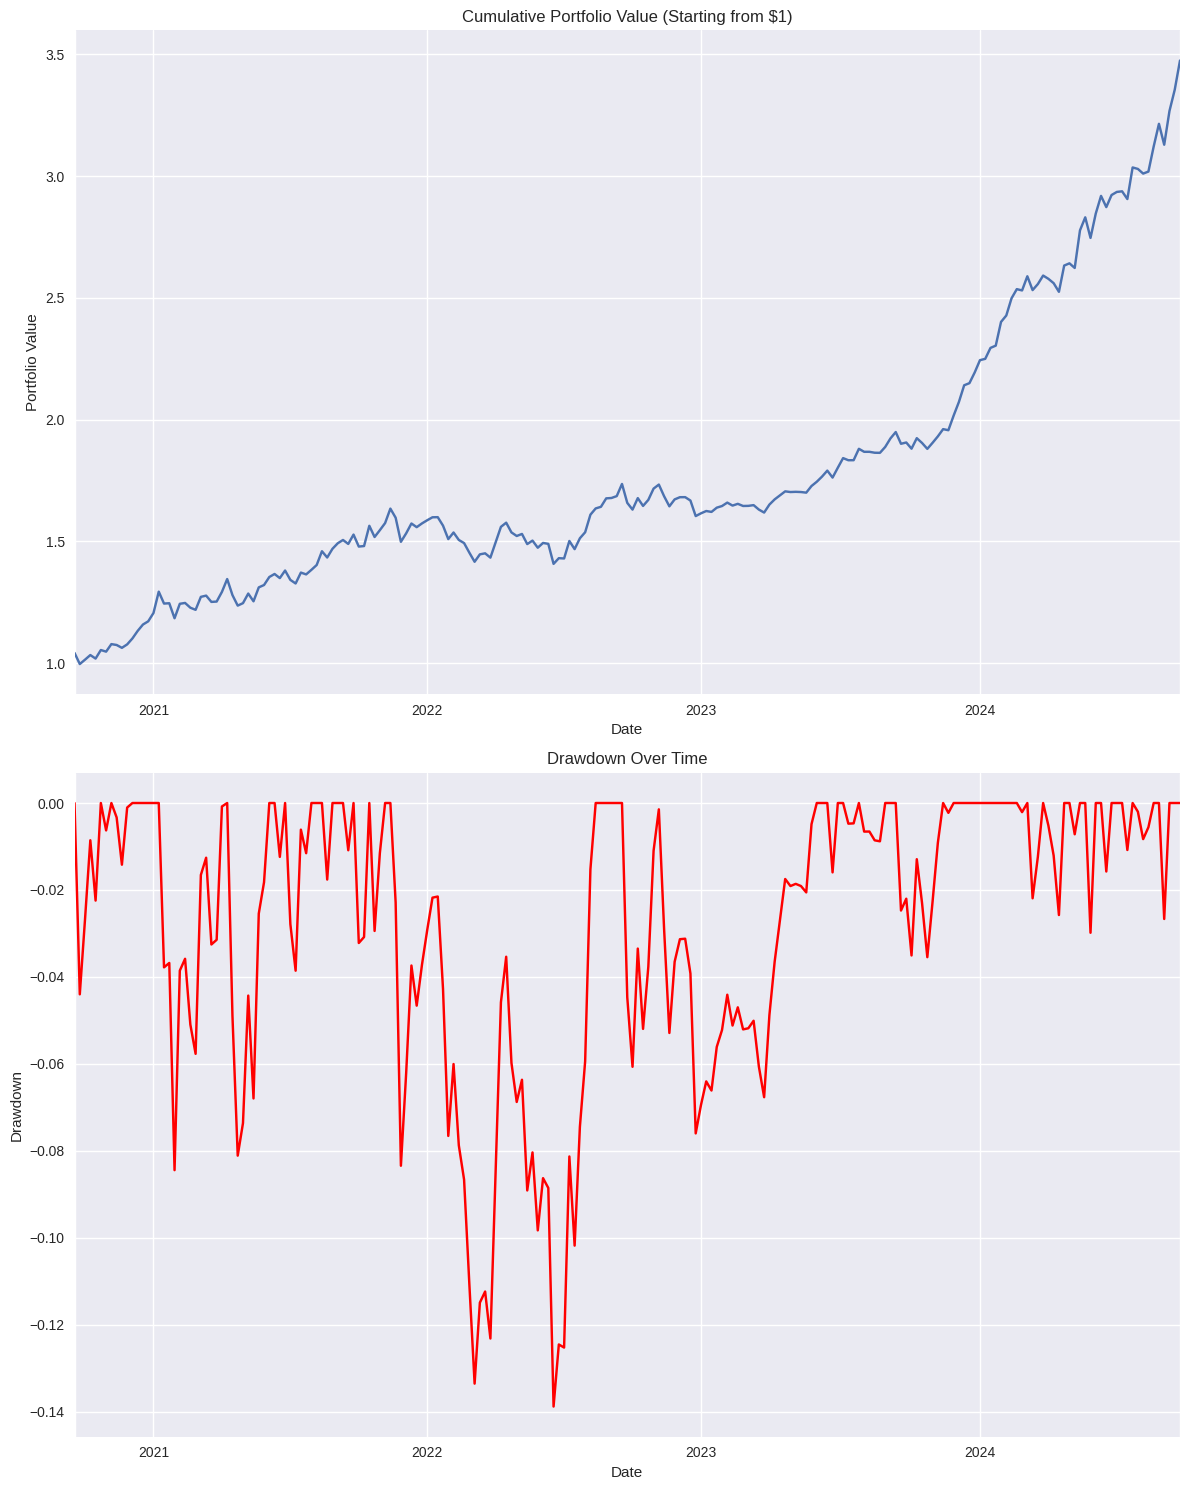


Final Portfolio Weights (as of 2024-09-26):
BHARTIARTL: 0.3390
SUNPHARMA: 0.1709
TRENT: 0.0886
NTPC: 0.0620
ONGC: 0.0521
BAJAJAUTO: 0.0501
powergrid: 0.0501
ADANIENT.1: 0.0451
INDIGO: 0.0362
VEDL: 0.0317
SIEMENS: 0.0221
M&M: 0.0212
HINDZINC: 0.0174
VBL: 0.0131
ABB: 0.0001
BEL: 0.0000
COALINDIA: 0.0000
ADANIGREEN: 0.0000
DLF: 0.0000
HAL: 0.0000


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cvxopt import matrix, solvers
import warnings
warnings.filterwarnings('ignore')

def calculate_weekly_returns(df):
    weekly_data = df.resample('W').last()
    weekly_returns = weekly_data.pct_change().dropna()
    return weekly_returns

def rank_stocks(weekly_returns, window=50):
    avg_returns = weekly_returns.rolling(window=window).mean()
    latest_avg_returns = avg_returns.iloc[-1].sort_values(ascending=False)
    return latest_avg_returns.index.tolist()

def get_top_stocks(ranked_stocks, n=20):
    return ranked_stocks[:n]

def minimum_variance_portfolio(covariance_matrix, initial_weights=None, lambda_cost=0.005):
    n = len(covariance_matrix)
    if initial_weights is None:
        initial_weights = np.ones(n) / n

    P = matrix(covariance_matrix)
    q = matrix(np.zeros(n))
    A = matrix(np.ones((1, n)))
    b = matrix(np.ones(1))

    G = matrix(np.vstack([
        np.eye(n),
        -np.eye(n),
        -np.eye(n)
    ]))

    h = matrix(np.hstack([
        initial_weights + 1,
        -initial_weights + 1,
        np.zeros(n)
    ]))

    solvers.options['show_progress'] = False
    solution = solvers.qp(P, q, G, h, A, b)

    if solution['status'] != 'optimal':
        raise ValueError("Optimization failed to converge")

    weights = np.array(solution['x']).flatten()
    return weights

def update_portfolio_optimization(weekly_returns, current_date, previous_weights=None):
    data_slice = weekly_returns.loc[:current_date].iloc[-50:]

    if len(data_slice) < 50:
        raise ValueError("Not enough historical data before the target date.")

    ranked_stocks = rank_stocks(data_slice)
    top_stocks = get_top_stocks(ranked_stocks)
    top_stock_returns = data_slice[top_stocks]
    cov_matrix = top_stock_returns.cov().values

    if previous_weights is None:
        initial_weights = None
    else:
        initial_weights = np.array([previous_weights.get(stock, 0) for stock in top_stocks])

    try:
        weights = minimum_variance_portfolio(cov_matrix, initial_weights)
        return dict(zip(top_stocks, weights))
    except ValueError as e:
        print(f"Optimization failed: {e}")
        return dict(zip(top_stocks, [1/len(top_stocks)] * len(top_stocks)))

def backtest_min_variance_strategy(df):
    weekly_returns = calculate_weekly_returns(df)
    portfolio_returns = []
    weightage_history = []
    previous_weights = None

    for i in range(50, len(weekly_returns)):
        current_date = weekly_returns.index[i-1]
        next_week = weekly_returns.index[i]

        try:
            weightage = update_portfolio_optimization(
                weekly_returns.iloc[:i],
                current_date,
                previous_weights
            )

            top_stocks = list(weightage.keys())
            weights = list(weightage.values())
            next_week_return = weekly_returns.loc[next_week][top_stocks].dot(weights)

            portfolio_returns.append(next_week_return)
            weightage_history.append((next_week, weightage))
            previous_weights = weightage

        except ValueError as e:
            print(f"Skipping week {next_week} due to: {e}")

    valid_index = weekly_returns.index[50:50+len(portfolio_returns)]
    return pd.Series(portfolio_returns, index=valid_index), weightage_history

def calculate_drawdown(cumulative_returns):
    drawdown = cumulative_returns / cumulative_returns.cummax() - 1
    max_drawdown = drawdown.min()
    return drawdown, max_drawdown

def sortino_ratio(returns, target=0, periods_per_year=52):
    downside_returns = returns[returns < target]
    downside_deviation = np.sqrt((downside_returns ** 2).mean()) * np.sqrt(periods_per_year)
    annualized_return = returns.mean() * periods_per_year
    return annualized_return / downside_deviation if downside_deviation != 0 else np.nan

def calmar_ratio(annualized_return, max_drawdown):
    return annualized_return / abs(max_drawdown) if max_drawdown != 0 else np.nan

def analyze_and_plot_results(df):
    print("Running backtest with minimum variance optimization...")
    portfolio_returns, weightage_history = backtest_min_variance_strategy(df)

    # Calculate performance metrics
    cumulative_returns = (1 + portfolio_returns).cumprod()
    total_return = cumulative_returns.iloc[-1]
    profit_only_return = total_return - 1
    annualized_return = (total_return ** (52/len(cumulative_returns)) - 1)
    annualized_volatility = portfolio_returns.std() * np.sqrt(52)
    sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(52)
    drawdown, max_drawdown = calculate_drawdown(cumulative_returns)
    sortino = sortino_ratio(portfolio_returns)
    calmar = calmar_ratio(annualized_return, max_drawdown)

    # Print performance metrics
    print("\nBacktest Results:")
    print(f"Total Return (including initial capital): {total_return:.4f}")
    print(f"This means for every $1 invested, you now have ${total_return:.2f}")
    print(f"Profit-only Return: {profit_only_return:.4%}")
    print(f"Annualized Return: {annualized_return:.2%}")
    print(f"Annualized Volatility: {annualized_volatility:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Sortino Ratio: {sortino:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2%}")
    print(f"Calmar Ratio: {calmar:.2f}")

    # Create plots
    plt.style.use('seaborn')
    fig, axes = plt.subplots(2, 1, figsize=(12, 15))

    # Plot 1: Cumulative Returns
    cumulative_returns.plot(ax=axes[0])
    axes[0].set_title('Cumulative Portfolio Value (Starting from $1)')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Portfolio Value')
    axes[0].grid(True)

    # Plot 2: Drawdown
    drawdown.plot(ax=axes[1], color='red')
    axes[1].set_title('Drawdown Over Time')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Drawdown')
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    # Print final portfolio weights
    last_date = df.index[-1]
    try:
        weekly_returns = calculate_weekly_returns(df)
        final_weights = update_portfolio_optimization(weekly_returns, last_date)
        print(f"\nFinal Portfolio Weights (as of {last_date.date()}):")
        for stock, weight in sorted(final_weights.items(), key=lambda x: x[1], reverse=True):
            print(f"{stock}: {weight:.4f}")
    except ValueError as e:
        print(f"\nCould not calculate final weights: {e}")

# Load and analyze data
df = pd.read_csv('total_df.csv', index_col='Date', parse_dates=True)
analyze_and_plot_results(df)

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.linalg import eigh
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

class NestedClusteringOptimizer:
    def __init__(self, returns, lambda_cost=0.0050):
        self.returns = returns
        self.lambda_cost = lambda_cost
        self.T, self.N = returns.shape
        self.ratio = self.T / self.N

    def calculate_covariance(self):
        return self.returns.cov()

    def find_optimal_k(self, corr_matrix, max_k=10):
        best_score = -1
        optimal_k = 2
        dist_matrix = np.sqrt(2 * (1 - corr_matrix))

        for k in range(2, min(max_k + 1, self.N)):
            kmeans = KMeans(n_clusters=k, random_state=42)
            cluster_labels = kmeans.fit_predict(corr_matrix)
            score = silhouette_score(dist_matrix, cluster_labels)
            if score > best_score:
                best_score = score
                optimal_k = k
        return optimal_k

    def denoise_covariance(self, cov_matrix):
        eigenvalues, eigenvectors = eigh(cov_matrix)
        eigenvalues = eigenvalues[::-1]
        eigenvectors = eigenvectors[:, ::-1]

        var = np.mean(eigenvalues)
        lambda_plus = var * (1 + np.sqrt(1/self.ratio))**2
        cutoff_idx = np.where(eigenvalues <= lambda_plus)[0][0]

        adjusted_eigenvalues = eigenvalues.copy()
        for j in range(cutoff_idx, len(eigenvalues)):
            adjusted_eigenvalues[j] = np.mean(eigenvalues[j:])

        denoised_cov = eigenvectors @ np.diag(adjusted_eigenvalues) @ eigenvectors.T
        std = np.sqrt(np.diag(denoised_cov))
        denoised_corr = denoised_cov / (std[:, None] @ std[None, :])

        return denoised_cov, denoised_corr

    def cluster_assets(self, corr_matrix, n_clusters=None):
        if n_clusters is None:
            n_clusters = self.find_optimal_k(corr_matrix)
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(corr_matrix)
        return clusters, n_clusters

    def optimize_cluster(self, returns, prev_weights=None):
        n = len(returns.columns)
        if prev_weights is None:
            prev_weights = np.array([1/n for _ in range(n)])

        def objective(weights):
            var = weights @ returns.cov() @ weights
            reg = self.lambda_cost * np.sum(np.abs(weights - prev_weights))
            return var + reg

        constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
        bounds = [(0, 1) for _ in range(n)]

        result = minimize(
            objective,
            prev_weights,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints
        )
        return result.x

    def optimize(self, prev_weights=None):
        V = self.calculate_covariance()
        V_denoised, C_denoised = self.denoise_covariance(V)
        clusters, K = self.cluster_assets(C_denoised)

        Omega_intra = np.zeros((self.N, K))
        for k in range(K):
            cluster_assets = np.where(clusters == k)[0]
            cluster_returns = self.returns.iloc[:, cluster_assets]

            if prev_weights is not None:
                prev_cluster_weights = prev_weights[cluster_assets]
            else:
                prev_cluster_weights = None

            cluster_weights = self.optimize_cluster(cluster_returns, prev_cluster_weights)
            Omega_intra[cluster_assets, k] = cluster_weights

        V_reduced = Omega_intra.T @ V_denoised @ Omega_intra
        Omega_inter = self.optimize_cluster(pd.DataFrame(self.returns @ Omega_intra))
        final_weights = Omega_intra @ Omega_inter

        return dict(zip(self.returns.columns, final_weights))

def calculate_weekly_returns(df):
    weekly_data = df.resample('W').last()
    weekly_returns = weekly_data.pct_change().dropna()
    return weekly_returns

def rank_stocks(weekly_returns, window=50):
    avg_returns = weekly_returns.rolling(window=window).mean()
    latest_avg_returns = avg_returns.iloc[-1].sort_values(ascending=False)
    return latest_avg_returns.index.tolist()

def get_top_stocks(ranked_stocks, n=20):
    return ranked_stocks[:n]

def get_stock_weightage(weekly_returns, current_date, prev_weights=None):
    data_slice = weekly_returns.loc[:current_date].iloc[-50:]

    if len(data_slice) < 50:
        raise ValueError("Not enough historical data before the target date.")

    ranked_stocks = rank_stocks(data_slice)
    top_stocks = get_top_stocks(ranked_stocks)
    top_stock_returns = data_slice[top_stocks]

    optimizer = NestedClusteringOptimizer(top_stock_returns)

    if prev_weights is not None:
        aligned_prev_weights = np.array([prev_weights.get(stock, 0) for stock in top_stocks])
        if sum(aligned_prev_weights) > 0:
            aligned_prev_weights = aligned_prev_weights / sum(aligned_prev_weights)
    else:
        aligned_prev_weights = None

    weights = optimizer.optimize(prev_weights=aligned_prev_weights)
    return weights

def backtest_strategy(df):
    weekly_returns = calculate_weekly_returns(df)
    portfolio_returns = []
    weightage_history = []
    prev_weightage = None

    for i in range(50, len(weekly_returns)):
        current_date = weekly_returns.index[i-1]
        next_week = weekly_returns.index[i]

        try:
            weightage = get_stock_weightage(
                weekly_returns.iloc[:i],
                current_date,
                prev_weights=prev_weightage
            )

            next_week_return = sum(
                weekly_returns.loc[next_week][stock] * weight
                for stock, weight in weightage.items()
            )

            portfolio_returns.append(next_week_return)
            weightage_history.append((next_week, weightage))
            prev_weightage = weightage

        except ValueError as e:
            print(f"Skipping week {next_week} due to error: {e}")

    valid_index = weekly_returns.index[50:50+len(portfolio_returns)]
    return pd.Series(portfolio_returns, index=valid_index), weightage_history

def calculate_performance_metrics(portfolio_returns):
    cumulative_returns = (1 + portfolio_returns).cumprod()
    total_return = cumulative_returns.iloc[-1]
    profit_only_return = total_return - 1
    annualized_return = (total_return ** (52/len(cumulative_returns)) - 1)
    annualized_volatility = portfolio_returns.std() * np.sqrt(52)
    sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(52)

    # Calculate drawdown
    drawdown = cumulative_returns / cumulative_returns.cummax() - 1
    max_drawdown = drawdown.min()

    # Calculate Sortino ratio
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_std = downside_returns.std() * np.sqrt(52)
    sortino_ratio = (portfolio_returns.mean() * 52) / downside_std if downside_std != 0 else np.nan

    # Calculate Calmar ratio
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else np.nan

    return {
        'Total Return': total_return,
        'Profit Return': profit_only_return,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Max Drawdown': max_drawdown,
        'Calmar Ratio': calmar_ratio
    }

# Main execution
if __name__ == "__main__":
    # Load the data
    df = pd.read_csv('total_df.csv', index_col='Date', parse_dates=True)

    # Run the backtest
    print("Running backtest...")
    portfolio_returns, weightage_history = backtest_strategy(df)

    # Calculate and display performance metrics
    metrics = calculate_performance_metrics(portfolio_returns)

    print("\nBacktest Results:")
    print(f"Total Return (including initial capital): {metrics['Total Return']:.4f}")
    print(f"This means for every $1 invested, you now have ${metrics['Total Return']:.2f}")
    print(f"Profit-only Return: {metrics['Profit Return']:.4%}")
    print(f"Annualized Return: {metrics['Annualized Return']:.2%}")
    print(f"Annualized Volatility: {metrics['Annualized Volatility']:.2%}")
    print(f"Sharpe Ratio: {metrics['Sharpe Ratio']:.2f}")
    print(f"Sortino Ratio: {metrics['Sortino Ratio']:.2f}")
    print(f"Max Drawdown: {metrics['Max Drawdown']:.2%}")
    print(f"Calmar Ratio: {metrics['Calmar Ratio']:.2f}")

    # Plot results
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    cumulative_returns = (1 + portfolio_returns).cumprod()
    cumulative_returns.plot()
    plt.title('Cumulative Portfolio Value (Starting from $1)')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    drawdown = cumulative_returns / cumulative_returns.cummax() - 1
    drawdown.plot(color='red')
    plt.title('Drawdown Over Time')
    plt.xlabel('Date')
    plt.ylabel('Drawdown')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Get final portfolio weights
    last_date = df.index[-1]
    try:
        final_weights = get_stock_weightage(calculate_weekly_returns(df), last_date)
        print(f"\nFinal portfolio weights for {last_date.date()}:")
        for stock, weight in final_weights.items():
            print(f"{stock}: {weight:.4f}")
    except ValueError as e:
        print(f"Error calculating final weights: {e}")

Running backtest...
Skipping week 2020-09-20 00:00:00 due to error: Input X contains NaN.
Skipping week 2020-09-27 00:00:00 due to error: Input X contains NaN.
Skipping week 2020-10-04 00:00:00 due to error: Input X contains NaN.
Skipping week 2020-10-11 00:00:00 due to error: Input X contains NaN.
Skipping week 2020-10-18 00:00:00 due to error: Input X contains NaN.
Skipping week 2020-10-25 00:00:00 due to error: Input X contains NaN.
Skipping week 2020-11-01 00:00:00 due to error: Input X contains NaN.
Skipping week 2020-11-08 00:00:00 due to error: Input X contains NaN.
Skipping week 2020-11-15 00:00:00 due to error: Input X contains NaN.
Skipping week 2020-11-22 00:00:00 due to error: Input X contains NaN.
Skipping week 2020-11-29 00:00:00 due to error: Input X contains NaN.
Skipping week 2020-12-06 00:00:00 due to error: Input X contains NaN.
Skipping week 2020-12-13 00:00:00 due to error: Input X contains NaN.
Skipping week 2020-12-20 00:00:00 due to error: Input X contains NaN.


IndexError: single positional indexer is out-of-bounds

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.linalg import eigh
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

class NestedClusteringOptimizer:
    def __init__(self, returns, lambda_cost=0.0050):
        self.returns = returns
        self.lambda_cost = lambda_cost
        self.T, self.N = returns.shape
        self.ratio = self.T / self.N

    def calculate_covariance(self):
        return self.returns.cov()

    def find_optimal_k(self, corr_matrix, max_k=10):
        best_score = -1
        optimal_k = 2
        dist_matrix = np.sqrt(2 * (1 - corr_matrix))

        for k in range(2, min(max_k + 1, self.N)):
            kmeans = KMeans(n_clusters=k, random_state=42)
            cluster_labels = kmeans.fit_predict(corr_matrix)
            score = silhouette_score(dist_matrix, cluster_labels)
            if score > best_score:
                best_score = score
                optimal_k = k
        return optimal_k

    def denoise_covariance(self, cov_matrix):
        eigenvalues, eigenvectors = eigh(cov_matrix)
        eigenvalues = eigenvalues[::-1]
        eigenvectors = eigenvectors[:, ::-1]

        var = np.mean(eigenvalues)
        lambda_plus = var * (1 + np.sqrt(1/self.ratio))**2
        cutoff_idx = np.where(eigenvalues <= lambda_plus)[0]
        cutoff_idx = cutoff_idx[0] if len(cutoff_idx) > 0 else len(eigenvalues)

        adjusted_eigenvalues = eigenvalues.copy()
        if cutoff_idx < len(eigenvalues):
            for j in range(cutoff_idx, len(eigenvalues)):
                adjusted_eigenvalues[j] = np.mean(eigenvalues[j:])

        denoised_cov = eigenvectors @ np.diag(adjusted_eigenvalues) @ eigenvectors.T
        std = np.sqrt(np.diag(denoised_cov))
        denoised_corr = denoised_cov / (std[:, None] @ std[None, :])

        return denoised_cov, denoised_corr

    def cluster_assets(self, corr_matrix, n_clusters=None):
        if n_clusters is None:
            n_clusters = self.find_optimal_k(corr_matrix)
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(corr_matrix)
        return clusters, n_clusters

    def optimize_cluster(self, returns, prev_weights=None):
        n = len(returns.columns)
        if prev_weights is None:
            prev_weights = np.array([1/n for _ in range(n)])

        def objective(weights):
            var = weights @ returns.cov() @ weights
            reg = self.lambda_cost * np.sum(np.abs(weights - prev_weights))
            return var + reg

        constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
        bounds = [(0.01, 1) for _ in range(n)]

        result = minimize(
            objective,
            prev_weights,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints
        )
        return result.x

    def optimize(self, prev_weights=None):
        V = self.calculate_covariance()
        V_denoised, C_denoised = self.denoise_covariance(V)
        clusters, K = self.cluster_assets(C_denoised)

        Omega_intra = np.zeros((self.N, K))
        for k in range(K):
            cluster_assets = np.where(clusters == k)[0]
            cluster_returns = self.returns.iloc[:, cluster_assets]

            if prev_weights is not None:
                prev_cluster_weights = prev_weights[cluster_assets]
            else:
                prev_cluster_weights = None

            cluster_weights = self.optimize_cluster(cluster_returns, prev_cluster_weights)
            Omega_intra[cluster_assets, k] = cluster_weights

        V_reduced = Omega_intra.T @ V_denoised @ Omega_intra
        Omega_inter = self.optimize_cluster(pd.DataFrame(self.returns @ Omega_intra))
        final_weights = Omega_intra @ Omega_inter

        return dict(zip(self.returns.columns, final_weights))

def calculate_weekly_returns(df):
    weekly_data = df.resample('W-FRI').last()  # Align to Friday for consistency
    weekly_returns = weekly_data.pct_change().dropna()
    return weekly_returns

def rank_stocks(weekly_returns, window=50):
    if len(weekly_returns) < window:
        raise ValueError(f"Not enough data points. Need at least {window} weeks.")
    avg_returns = weekly_returns.rolling(window=window).mean()
    latest_avg_returns = avg_returns.iloc[-1].sort_values(ascending=False)
    return latest_avg_returns.index.tolist()

def get_top_stocks(ranked_stocks, n=20):
    return ranked_stocks[:min(n, len(ranked_stocks))]

def get_stock_weightage(weekly_returns, current_date, prev_weights=None):
    # Ensure we're only using data up to current_date
    data_slice = weekly_returns[weekly_returns.index <= current_date].last('50W')

    if len(data_slice) < 50:
        raise ValueError(f"Need at least 50 weeks of data before {current_date}")

    ranked_stocks = rank_stocks(data_slice)
    top_stocks = get_top_stocks(ranked_stocks)
    top_stock_returns = data_slice[top_stocks].dropna()

    optimizer = NestedClusteringOptimizer(top_stock_returns)

    if prev_weights is not None:
        aligned_prev_weights = np.array([prev_weights.get(stock, 0) for stock in top_stocks])
        if sum(aligned_prev_weights) > 0:
            aligned_prev_weights = aligned_prev_weights / sum(aligned_prev_weights)
    else:
        aligned_prev_weights = None

    weights = optimizer.optimize(prev_weights=aligned_prev_weights)
    return weights

def backtest_strategy(df):
    weekly_returns = calculate_weekly_returns(df)
    portfolio_returns = []
    weightage_history = []
    prev_weightage = None

    # Start from the 51st week to ensure enough historical data
    start_idx = 50

    for i in range(start_idx, len(weekly_returns)):
        try:
            current_date = weekly_returns.index[i-1]
            next_week = weekly_returns.index[i]

            # Get historical data up to current date
            historical_data = weekly_returns.iloc[:i]

            weightage = get_stock_weightage(
                historical_data,
                current_date,
                prev_weights=prev_weightage
            )

            # Calculate next week's return
            next_week_returns = weekly_returns.loc[next_week]
            portfolio_return = sum(
                next_week_returns[stock] * weight
                for stock, weight in weightage.items()
                if stock in next_week_returns.index
            )

            portfolio_returns.append(portfolio_return)
            weightage_history.append((next_week, weightage))
            prev_weightage = weightage

        except Exception as e:
            print(f"Warning: Error at week {next_week}: {str(e)}")
            continue

    if not portfolio_returns:
        raise ValueError("No valid returns were calculated during the backtest period")

    return pd.Series(portfolio_returns, index=weekly_returns.index[start_idx+1:start_idx+1+len(portfolio_returns)]), weightage_history

def calculate_performance_metrics(portfolio_returns):
    if len(portfolio_returns) == 0:
        raise ValueError("Empty portfolio returns series")

    cumulative_returns = (1 + portfolio_returns).cumprod()
    total_return = cumulative_returns.iloc[-1]
    profit_only_return = total_return - 1
    annualized_return = (total_return ** (52/len(cumulative_returns)) - 1)
    annualized_volatility = portfolio_returns.std() * np.sqrt(52)
    sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(52)

    drawdown = cumulative_returns / cumulative_returns.cummax() - 1
    max_drawdown = drawdown.min()

    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_std = downside_returns.std() * np.sqrt(52)
    sortino_ratio = (portfolio_returns.mean() * 52) / downside_std if downside_std != 0 else np.nan

    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else np.nan

    return {
        'Total Return': total_return,
        'Profit Return': profit_only_return,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Max Drawdown': max_drawdown,
        'Calmar Ratio': calmar_ratio
    }

if __name__ == "__main__":
    # Load the data
    df = pd.read_csv('total_df.csv', index_col='Date', parse_dates=True)
    df = df.sort_index()  # Ensure data is sorted by date

    print("Running backtest...")
    try:
        portfolio_returns, weightage_history = backtest_strategy(df)

        # Calculate and display performance metrics
        metrics = calculate_performance_metrics(portfolio_returns)

        print("\nBacktest Results:")
        print(f"Total Return (including initial capital): {metrics['Total Return']:.4f}")
        print(f"This means for every $1 invested, you now have ${metrics['Total Return']:.2f}")
        print(f"Profit-only Return: {metrics['Profit Return']:.4%}")
        print(f"Annualized Return: {metrics['Annualized Return']:.2%}")
        print(f"Annualized Volatility: {metrics['Annualized Volatility']:.2%}")
        print(f"Sharpe Ratio: {metrics['Sharpe Ratio']:.2f}")
        print(f"Sortino Ratio: {metrics['Sortino Ratio']:.2f}")
        print(f"Max Drawdown: {metrics['Max Drawdown']:.2%}")
        print(f"Calmar Ratio: {metrics['Calmar Ratio']:.2f}")

        # Plot results
        import matplotlib.pyplot as plt

        plt.figure(figsize=(12, 8))
        plt.subplot(2, 1, 1)
        cumulative_returns = (1 + portfolio_returns).cumprod()
        cumulative_returns.plot()
        plt.title('Cumulative Portfolio Value (Starting from $1)')
        plt.xlabel('Date')
        plt.ylabel('Portfolio Value')
        plt.grid(True)

        plt.subplot(2, 1, 2)
        drawdown = cumulative_returns / cumulative_returns.cummax() - 1
        drawdown.plot(color='red')
        plt.title('Drawdown Over Time')
        plt.xlabel('Date')
        plt.ylabel('Drawdown')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Get final portfolio weights
        last_date = df.index[-1]
        try:
            final_weights = get_stock_weightage(calculate_weekly_returns(df), last_date)
            print(f"\nFinal portfolio weights for {last_date.date()}:")
            sorted_weights = sorted(final_weights.items(), key=lambda x: x[1], reverse=True)
            for stock, weight in sorted_weights:
                print(f"{stock}: {weight:.4f}")
        except ValueError as e:
            print(f"Error calculating final weights: {e}")

    except Exception as e:
        print(f"Error during backtest execution: {str(e)}")

Running backtest...
Error during backtest execution: No valid returns were calculated during the backtest period


Running backtest...

Backtest Results:
Total Return (including initial capital): 4.3980
This means for every $1 invested, you now have $4.40
Profit-only Return: 339.7971%
Annualized Return: 44.05%
Annualized Volatility: 17.39%
Sharpe Ratio: 2.19
Sortino Ratio: 2.15
Max Drawdown: -12.80%
Calmar Ratio: 3.44


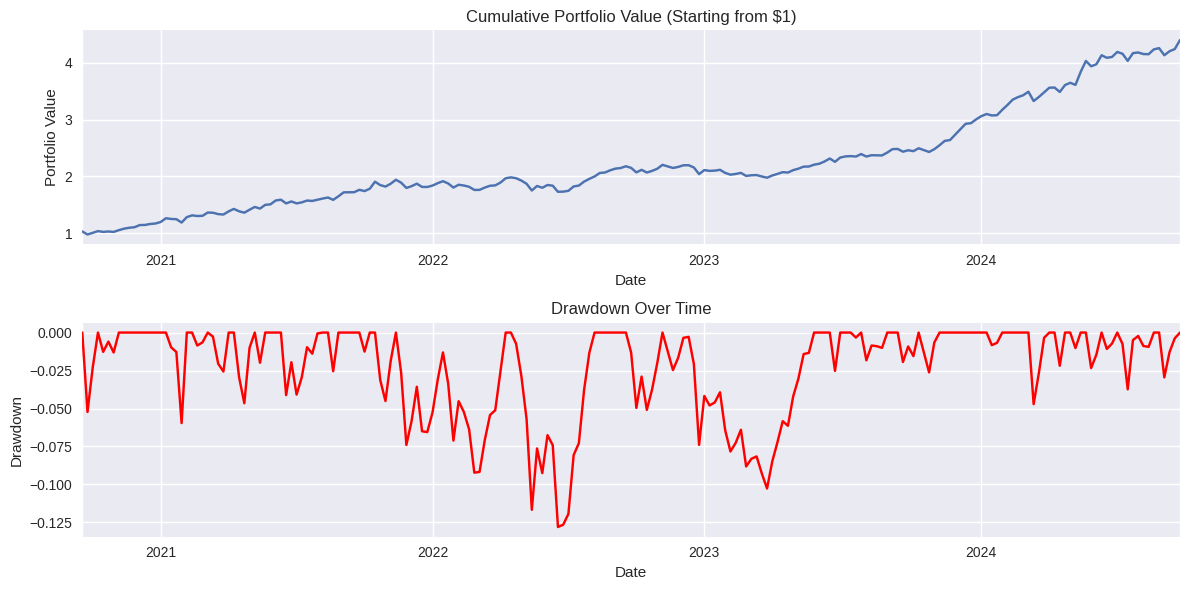


Stock weightage for week of 2024-09-26:
TRENT: 0.0500
BAJAJAUTO: 0.0500
HAL: 0.0500
VEDL: 0.0500
ADANIGREEN: 0.0500
BEL: 0.0500
SIEMENS: 0.0500
INDIGO: 0.0500
HINDZINC: 0.0500
ABB: 0.0500
NTPC: 0.0500
M&M: 0.0500
COALINDIA: 0.0500
BHARTIARTL: 0.0500
VBL: 0.0500
powergrid: 0.0500
ADANIENT.1: 0.0500
ONGC: 0.0500
SUNPHARMA: 0.0500
DLF: 0.0500


In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def calculate_weekly_returns(df):
    weekly_data = df.resample('W').last()
    weekly_returns = weekly_data.pct_change().dropna()
    return weekly_returns

def rank_stocks(weekly_returns, window=50):
    avg_returns = weekly_returns.rolling(window=window).mean()
    latest_avg_returns = avg_returns.iloc[-1].sort_values(ascending=False)
    return latest_avg_returns.index.tolist()

def get_top_stocks(ranked_stocks, n=20):
    return ranked_stocks[:n]

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def create_min_variance_portfolio(returns, initial_weights=None, lambda_reg=0.005):
    """
    Creates a minimum variance portfolio while including transaction costs using l1-regularization.
    :param returns: DataFrame containing historical stock returns.
    :param initial_weights: Initial portfolio weights (w0 in the formulation).
    :param lambda_reg: Regularization parameter controlling transaction costs.
    :return: Optimal weights for the portfolio.
    """
    n = len(returns.columns)
    init_guess = np.array([1/n for _ in range(n)])
    bounds = tuple((0, 1) for _ in range(n))

    # If initial weights are not provided, assume equal weighting
    if initial_weights is None:
        initial_weights = np.array([1/n for _ in range(n)])

    cov_matrix = returns.cov()

    def objective_function(weights):
        # Minimize portfolio variance with a penalty for changes in weights (l1 norm)
        variance = portfolio_variance(weights, cov_matrix)
        penalty = lambda_reg * np.sum(np.abs(weights - initial_weights))
        return variance + penalty

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    result = minimize(objective_function, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)

    return result.x

def get_stock_weightage(weekly_returns, current_date, prev_weights=None):
    data_slice = weekly_returns.loc[:current_date].iloc[-50:]

    if len(data_slice) < 50:
        raise ValueError("Not enough historical data before the target date.")

    ranked_stocks = rank_stocks(data_slice)
    top_stocks = get_top_stocks(ranked_stocks)
    top_stock_returns = data_slice[top_stocks]

    # If previous weights are provided, pass them to the optimizer, else default to equal weights
    weights = create_min_variance_portfolio(top_stock_returns, prev_weights)
    stock_weights = dict(zip(top_stocks, weights))

    return stock_weights

def calculate_drawdown(cumulative_returns):
    drawdown = cumulative_returns / cumulative_returns.cummax() - 1
    max_drawdown = drawdown.min()
    return drawdown, max_drawdown

def sortino_ratio(returns, target=0, periods_per_year=52):
    downside_returns = returns[returns < target]
    downside_deviation = np.sqrt((downside_returns ** 2).mean()) * np.sqrt(periods_per_year)
    annualized_return = returns.mean() * periods_per_year
    return annualized_return / downside_deviation if downside_deviation != 0 else np.nan

def calmar_ratio(annualized_return, max_drawdown):
    return annualized_return / abs(max_drawdown) if max_drawdown != 0 else np.nan

def backtest_strategy(df):
    weekly_returns = calculate_weekly_returns(df)
    portfolio_returns = []
    weightage_history = []
    prev_weights = None  # Store previous weights to pass into the next rebalancing

    for i in range(50, len(weekly_returns)):
        current_date = weekly_returns.index[i-1]
        next_week = weekly_returns.index[i]

        try:
            weightage = get_stock_weightage(weekly_returns.iloc[:i], current_date, prev_weights)
            prev_weights = list(weightage.values())  # Save current weights for the next iteration
            top_stocks = list(weightage.keys())
            weights = list(weightage.values())

            next_week_return = weekly_returns.loc[next_week][top_stocks].dot(weights)
            portfolio_returns.append(next_week_return)
            weightage_history.append((next_week, weightage))

        except ValueError:
            print(f"Skipping week {next_week} due to insufficient data")

    # Adjust to make sure the length of portfolio_returns and index match
    valid_index = weekly_returns.index[50:50+len(portfolio_returns)]

    return pd.Series(portfolio_returns, index=valid_index), weightage_history

# Load the data
df = pd.read_csv('total_df.csv', index_col='Date', parse_dates=True)

# Run the backtest
print("Running backtest...")
portfolio_returns, weightage_history = backtest_strategy(df)

# Calculate cumulative returns and metrics
cumulative_returns = (1 + portfolio_returns).cumprod()
total_return = cumulative_returns.iloc[-1]
profit_only_return = total_return - 1
annualized_return = (total_return ** (52/len(cumulative_returns)) - 1)
annualized_volatility = portfolio_returns.std() * np.sqrt(52)
sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(52)

# Calculate drawdown and additional metrics
drawdown, max_drawdown = calculate_drawdown(cumulative_returns)
calmar = calmar_ratio(annualized_return, max_drawdown)
sortino = sortino_ratio(portfolio_returns)

# Print backtest results
print("\nBacktest Results:")
print(f"Total Return (including initial capital): {total_return:.4f}")
print(f"This means for every $1 invested, you now have ${total_return:.2f}")
print(f"Profit-only Return: {profit_only_return:.4%}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar:.2f}")

# Plot cumulative returns and drawdown
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
cumulative_returns.plot()
plt.title('Cumulative Portfolio Value (Starting from $1)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)

plt.subplot(2, 1, 2)
drawdown.plot(color='red')
plt.title('Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)

plt.tight_layout()
plt.show()

# Get weightage for the last date in the dataset
last_date = df.index[-1]
try:
    weightage = get_stock_weightage(calculate_weekly_returns(df), last_date)
    print(f"\nStock weightage for week of {last_date.date()}:")
    for stock, weight in weightage.items():
        print(f"{stock}: {weight:.4f}")
except ValueError as e:
    print(f"Error: {e}")


<ipython-input-12-516c9b8eef3b>:262: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('total_df.csv', index_col='Date', parse_dates=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_weights[cluster] = weights

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_weights[cluster] = weights * cluster_weights[cluster]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_weights[cluster] = weights * cluster_weights[cluster]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_weights[cluster] = weights * cluster_weights[cluster]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_weights[cluster] = weights * cluster_weights[cluster]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_weights[cluster] = weights * cluster_weights[cluster]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_weights[cluster] = weights * cluster_weights[cluster]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_weights[cluster] = weights * cluster_weights[cluster]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_weights[cluster] = weights * cluster_weights[cluster]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(

<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_weights[cluster] = weights * cluster_weights[cluster]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(

<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_weights[cluster] = weights * cluster_weights[cluster]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_weights[cluster] = weights

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_weights[cluster] = weights

<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_weights[cluster] = weights * cluster_weights[cluster]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_weights[cluster] = weights * cluster_weights[cluster]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_weights[cluster] = weights

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_weights[cluster] = weights * cluster_weights[cluster]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_weights[cluster] = weights * cluster_weights[cluster]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_weights[cluster] = weights * cluster_weights[cluster]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_weights[cluster] = weights * cluster_weights[cluster]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_weights[cluster] = weights * cluster_weights[cluster]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_weights[cluster] = weights * cluster_weights[cluster]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_weights[cluster] = weights * cluster_weights[cluster]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_weights[cluster] = weights * cluster_weights[cluster]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
<ipython-input-12-516c9b8eef3b>:143: DeprecationWarning:


Backtest Results:
Total Return: 4.3980
Annualized Return: 44.05%
Annualized Volatility: 17.39%
Sharpe Ratio: 2.19


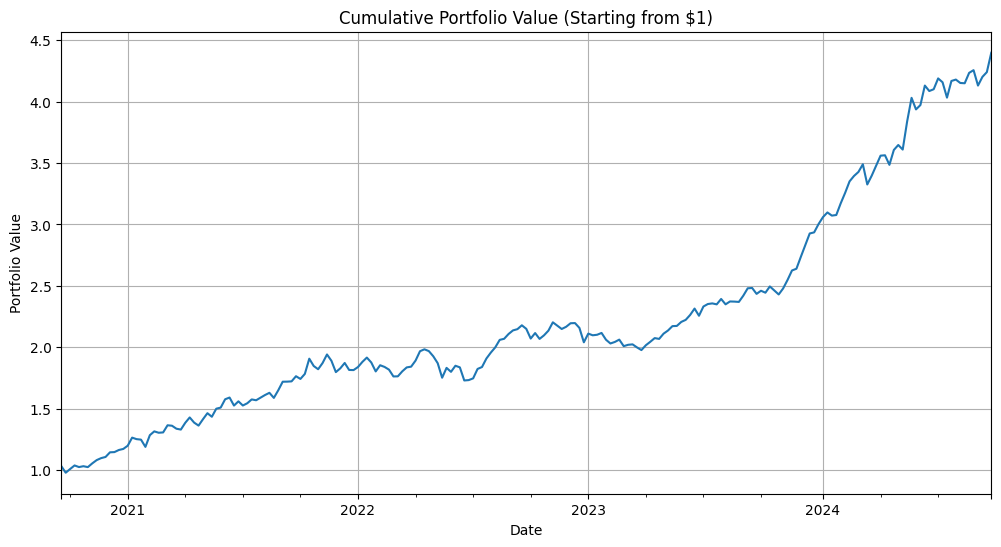

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Calculate weekly returns
def calculate_weekly_returns(df):
    if isinstance(df, pd.Series):
        df = df.to_frame()
    weekly_returns = df.resample('W').last().pct_change().dropna()
    return weekly_returns

# Rank stocks by their returns
def rank_stocks(weekly_returns, window=50):
    if isinstance(weekly_returns, pd.Series):
        return [weekly_returns.name]  # Return single stock name if Series
    avg_returns = weekly_returns.rolling(window=window).mean()
    latest_avg_returns = avg_returns.iloc[-1].sort_values(ascending=False)
    return latest_avg_returns.index.tolist()

# Get top n stocks from ranked list
def get_top_stocks(ranked_stocks, n=20):
    return ranked_stocks[:min(n, len(ranked_stocks))]

# Portfolio variance calculation
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Create minimum variance portfolio
def create_min_variance_portfolio(returns, lambd=0.005, w0=None):
    if isinstance(returns, pd.Series):
        return np.array([1.0])  # Return single weight if Series

    n = len(returns.columns)
    init_guess = np.array([1/n for _ in range(n)])
    bounds = tuple((0, 1) for _ in range(n))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    cov_matrix = returns.cov()

    def obj_func(w):
        penalty = lambd * np.sum(np.abs(w - w0)) if w0 is not None else 0
        return portfolio_variance(w, cov_matrix) + penalty

    try:
        result = minimize(obj_func, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
        if result.success:
            return result.x
        else:
            return init_guess
    except:
        return init_guess

# Denoise the covariance matrix using Marc̆enko-Pastur distribution
def denoise_covariance(cov_matrix, tn_relation):
    try:
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        eigenvalues = np.maximum(eigenvalues, 0)  # Remove negative eigenvalues
        q = len(cov_matrix) / tn_relation
        max_eigenvalue = (1 + np.sqrt(1 / q))**2
        denoised_eigenvalues = np.where(eigenvalues > max_eigenvalue, eigenvalues, 0)
        denoised_cov_matrix = np.dot(eigenvectors, np.dot(np.diag(denoised_eigenvalues), eigenvectors.T))

        # Ensure the matrix is symmetric
        denoised_cov_matrix = (denoised_cov_matrix + denoised_cov_matrix.T) / 2

        return denoised_cov_matrix
    except Exception as e:
        print(f"Warning in denoise_covariance: {str(e)}")
        return cov_matrix

def nested_clustering_optimization(cov_matrix, n_clusters):
    if len(cov_matrix) == 1:
        return cov_matrix, np.array([1.0])

    # Standardize the distance matrix to help with clustering
    dist_matrix = np.sqrt(2 * (1 - cov_matrix))
    scaler = StandardScaler()
    scaled_dist_matrix = scaler.fit_transform(dist_matrix)

    # Determine optimal number of clusters
    max_clusters = min(n_clusters, len(cov_matrix))
    optimal_n_clusters = max_clusters

    # Try clustering with decreasing number of clusters until we get valid clusters
    while optimal_n_clusters > 1:
        kmeans = KMeans(n_clusters=optimal_n_clusters, n_init=10)
        clusters = kmeans.fit_predict(scaled_dist_matrix)

        # Check if we have at least two different clusters
        unique_clusters = len(np.unique(clusters))
        if unique_clusters > 1:
            break
        optimal_n_clusters -= 1

    # If we couldn't find multiple clusters, return equal weights
    if optimal_n_clusters == 1:
        print(f"Warning: Could not find multiple distinct clusters. Using {len(cov_matrix)} equal weights.")
        return cov_matrix, np.array([1.0/len(cov_matrix)] * len(cov_matrix))

    clustered_cov_matrix = np.zeros_like(cov_matrix)
    cluster_weights = np.zeros(optimal_n_clusters)

    # Calculate cluster weights
    for cluster in range(optimal_n_clusters):
        indices = np.where(clusters == cluster)[0]
        if len(indices) > 0:
            cluster_cov_matrix = cov_matrix[np.ix_(indices, indices)]
            cluster_var = np.trace(cluster_cov_matrix)  # Use trace instead of sum

            # Avoid division by zero
            if cluster_var > 0:
                cluster_weights[cluster] = 1.0 / cluster_var
            else:
                cluster_weights[cluster] = 1.0  # Equal weight if variance is zero

            clustered_cov_matrix[np.ix_(indices, indices)] = cluster_cov_matrix

    # Normalize cluster weights
    total_weight = np.sum(cluster_weights)
    if total_weight > 0:
        cluster_weights = cluster_weights / total_weight
    else:
        cluster_weights = np.array([1.0/optimal_n_clusters] * optimal_n_clusters)

    return clustered_cov_matrix, cluster_weights

def minimize_variance_within_clusters(clustered_cov_matrix, cluster_weights, returns):
    if isinstance(returns, pd.Series):
        return np.array([1.0])

    n_assets = len(returns.columns)
    final_weights = np.zeros(n_assets)

    try:
        for cluster in range(len(cluster_weights)):
            if cluster_weights[cluster] > 0:
                cluster_return = returns.iloc[:, [cluster]]  # Keep as DataFrame
                try:
                    weights = create_min_variance_portfolio(cluster_return)
                    final_weights[cluster] = weights * cluster_weights[cluster]
                except:
                    # If optimization fails, use equal weights for this cluster
                    final_weights[cluster] = cluster_weights[cluster]
    except Exception as e:
        print(f"Warning: Error in minimize_variance_within_clusters: {str(e)}")
        # Fallback to equal weights
        final_weights = np.array([1.0/n_assets] * n_assets)

    # Ensure weights sum to 1
    weight_sum = np.sum(final_weights)
    if weight_sum > 0:
        final_weights = final_weights / weight_sum
    else:
        final_weights = np.array([1.0/n_assets] * n_assets)

    return final_weights

def get_stock_weightage_nco(weekly_returns, current_date, n_clusters, tn_relation):
    try:
        data_slice = weekly_returns.loc[:current_date].iloc[-50:]

        if len(data_slice) < 50:
            raise ValueError("Not enough historical data before the target date.")

        if isinstance(data_slice, pd.Series):
            return {data_slice.name: 1.0}

        ranked_stocks = rank_stocks(data_slice)
        top_stocks = get_top_stocks(ranked_stocks)
        top_stock_returns = data_slice[top_stocks]

        # Handle case where we have only one stock
        if len(top_stocks) == 1:
            return {top_stocks[0]: 1.0}

        # Covariance matrix
        cov_matrix = top_stock_returns.cov()

        # Ensure covariance matrix is positive definite
        min_eigenvalue = np.min(np.linalg.eigvals(cov_matrix))
        if min_eigenvalue < 0:
            cov_matrix -= 1.1 * min_eigenvalue * np.eye(len(cov_matrix))

        # Adjust n_clusters if we have fewer stocks than clusters
        n_clusters = min(n_clusters, len(top_stocks))

        # Step 1: De-noise covariance matrix
        denoised_cov_matrix = denoise_covariance(cov_matrix, tn_relation)

        # Step 2: Apply clustering
        clustered_cov_matrix, cluster_weights = nested_clustering_optimization(denoised_cov_matrix, n_clusters)

        # Step 3: Minimize variance within clusters
        final_weights = minimize_variance_within_clusters(clustered_cov_matrix, cluster_weights, top_stock_returns)

        # Ensure weights sum to 1 and are non-negative
        final_weights = np.maximum(final_weights, 0)
        final_weights = final_weights / np.sum(final_weights)

        stock_weights = dict(zip(top_stocks, final_weights))
        return stock_weights

    except Exception as e:
        print(f"Warning in get_stock_weightage_nco: {str(e)}")
        # Fallback to equal weights for all stocks
        equal_weight = 1.0 / len(weekly_returns.columns)
        return dict(zip(weekly_returns.columns, [equal_weight] * len(weekly_returns.columns)))

def nco_backtest_strategy(df, n_clusters=5, tn_relation=1):
    weekly_returns = calculate_weekly_returns(df)
    portfolio_returns = []
    weightage_history = []

    # Iterate over the dates in weekly returns
    for i in range(50, len(weekly_returns)):
        current_date = weekly_returns.index[i - 1]
        next_week = weekly_returns.index[i]

        try:
            # Get stock weights using nested clustering optimization
            weightage = get_stock_weightage_nco(weekly_returns.iloc[:i], current_date, n_clusters, tn_relation)
            top_stocks = list(weightage.keys())
            weights = list(weightage.values())

            # Calculate portfolio returns for the next week
            next_week_return = weekly_returns.loc[next_week][top_stocks].dot(weights)
            portfolio_returns.append(next_week_return)
            weightage_history.append((next_week, weightage))

        except Exception as e:
            print(f"Warning: Error in week {next_week}: {str(e)}")
            # Skip this week if there's an error
            continue

    valid_index = weekly_returns.index[50:50+len(portfolio_returns)]
    return pd.Series(portfolio_returns, index=valid_index), weightage_history

def calculate_performance_metrics(portfolio_returns):
    cumulative_returns = (1 + portfolio_returns).cumprod()
    total_return = cumulative_returns.iloc[-1]
    annualized_return = (total_return ** (52 / len(cumulative_returns)) - 1)
    annualized_volatility = portfolio_returns.std() * np.sqrt(52)
    sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(52)

    return total_return, annualized_return, annualized_volatility, sharpe_ratio

def plot_portfolio_performance(portfolio_returns):
    plt.figure(figsize=(12, 6))
    (1 + portfolio_returns).cumprod().plot()
    plt.title('Cumulative Portfolio Value (Starting from $1)')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.grid(True)
    plt.show()

# Example usage:
if __name__ == "__main__":
    # Load your data
    df = pd.read_csv('total_df.csv', index_col='Date', parse_dates=True)

    # Run the backtest
    portfolio_returns, weightage_history = nco_backtest_strategy(df, n_clusters=5, tn_relation=1)

    # Calculate and display metrics
    total_return, annualized_return, annualized_volatility, sharpe_ratio = calculate_performance_metrics(portfolio_returns)

    print("\nBacktest Results:")
    print(f"Total Return: {total_return:.4f}")
    print(f"Annualized Return: {annualized_return:.2%}")
    print(f"Annualized Volatility: {annualized_volatility:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

    # Plot the results
    plot_portfolio_performance(portfolio_returns)

<ipython-input-14-646d567cab54>:301: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('total_df.csv', index_col='Date', parse_dates=True)
<ipython-input-14-646d567cab54>:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_weights[cluster] = weights * cluster_weights[cluster]
<ipython-input-14-646d567cab54>:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_weights[cluster] = weights * cluster_weights[cluster]
<ipython-input-14-646d567cab54>:154: DeprecationWarning: Conversion of an array with ndim >

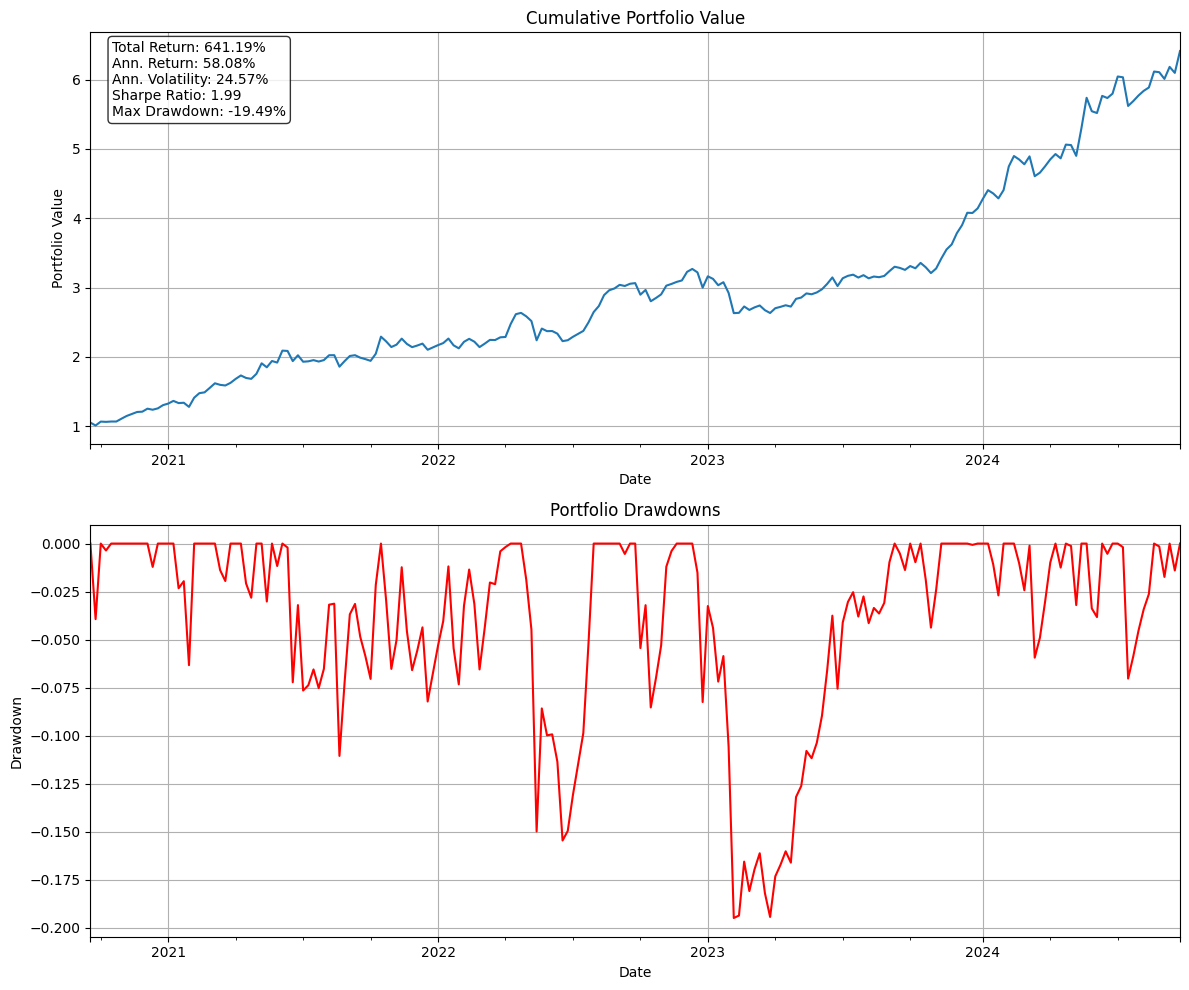

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def calculate_weekly_returns(df):
    if isinstance(df, pd.Series):
        df = df.to_frame()
    weekly_returns = df.resample('W').last().pct_change().dropna()
    return weekly_returns

def rank_stocks(weekly_returns, window=50):
    if isinstance(weekly_returns, pd.Series):
        return [weekly_returns.name]
    avg_returns = weekly_returns.rolling(window=window).mean()
    latest_avg_returns = avg_returns.iloc[-1].sort_values(ascending=False)
    return latest_avg_returns.index.tolist()

def get_top_stocks(ranked_stocks, n=20):
    return ranked_stocks[:min(n, len(ranked_stocks))]

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def create_min_variance_portfolio(returns, lambd=0.005, w0=None):
    if isinstance(returns, pd.Series):
        return np.array([1.0])

    n = len(returns.columns)
    init_guess = np.array([1/n for _ in range(n)])
    bounds = tuple((0, 1) for _ in range(n))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    cov_matrix = returns.cov()

    def obj_func(w):
        penalty = lambd * np.sum(np.abs(w - w0)) if w0 is not None else 0
        return portfolio_variance(w, cov_matrix) + penalty

    try:
        result = minimize(obj_func, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
        if result.success:
            return result.x
        else:
            return init_guess
    except:
        return init_guess

def denoise_covariance(cov_matrix, tn_relation):
    try:
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        eigenvalues = np.maximum(eigenvalues, 0)
        q = len(cov_matrix) / tn_relation
        max_eigenvalue = (1 + np.sqrt(1 / q))**2
        denoised_eigenvalues = np.where(eigenvalues > max_eigenvalue, eigenvalues, 0)
        denoised_cov_matrix = np.dot(eigenvectors, np.dot(np.diag(denoised_eigenvalues), eigenvectors.T))

        # Ensure the matrix is symmetric
        denoised_cov_matrix = (denoised_cov_matrix + denoised_cov_matrix.T) / 2

        return denoised_cov_matrix
    except Exception as e:
        print(f"Warning in denoise_covariance: {str(e)}")
        return cov_matrix

def nested_clustering_optimization(cov_matrix, n_clusters):
    if len(cov_matrix) == 1:
        return cov_matrix, np.array([1.0])

    # Create distance matrix
    dist_matrix = np.sqrt(2 * (1 - cov_matrix))

    # Standardize and add small noise to help with clustering
    scaler = StandardScaler()
    scaled_dist_matrix = scaler.fit_transform(dist_matrix)

    # Add small random noise to break ties and avoid duplicate points
    np.random.seed(42)  # for reproducibility
    scaled_dist_matrix += np.random.normal(0, 0.0001, scaled_dist_matrix.shape)

    # Determine optimal number of clusters using silhouette score
    max_clusters = min(n_clusters, len(cov_matrix) - 1)
    best_score = -1
    best_n_clusters = 2  # Start with minimum of 2 clusters
    best_clusters = None

    for n in range(2, max_clusters + 1):
        try:
            kmeans = KMeans(n_clusters=n, n_init=20, max_iter=300)
            clusters = kmeans.fit_predict(scaled_dist_matrix)

            if len(np.unique(clusters)) < n:
                continue

            score = silhouette_score(scaled_dist_matrix, clusters)

            if score > best_score:
                best_score = score
                best_n_clusters = n
                best_clusters = clusters
        except:
            continue

    # If clustering failed, use hierarchical clustering as fallback
    if best_clusters is None or len(np.unique(best_clusters)) < 2:
        try:
            clustering = AgglomerativeClustering(n_clusters=2)
            best_clusters = clustering.fit_predict(scaled_dist_matrix)
            best_n_clusters = 2
            print("Switched to hierarchical clustering with 2 clusters")
        except:
            print(f"Using {len(cov_matrix)} equal weights as clustering failed")
            return cov_matrix, np.array([1.0/len(cov_matrix)] * len(cov_matrix))

    clustered_cov_matrix = np.zeros_like(cov_matrix)
    cluster_weights = np.zeros(best_n_clusters)

    # Calculate cluster weights using inverse variance
    for cluster in range(best_n_clusters):
        indices = np.where(best_clusters == cluster)[0]
        if len(indices) > 0:
            cluster_cov_matrix = cov_matrix[np.ix_(indices, indices)]

            # Use robust variance estimation
            cluster_var = max(np.trace(cluster_cov_matrix), 1e-8)
            cluster_weights[cluster] = 1.0 / cluster_var
            clustered_cov_matrix[np.ix_(indices, indices)] = cluster_cov_matrix

    # Normalize cluster weights
    total_weight = np.sum(cluster_weights)
    if total_weight > 0:
        cluster_weights = cluster_weights / total_weight
    else:
        cluster_weights = np.array([1.0/best_n_clusters] * best_n_clusters)

    return clustered_cov_matrix, cluster_weights

def minimize_variance_within_clusters(clustered_cov_matrix, cluster_weights, returns):
    if isinstance(returns, pd.Series):
        return np.array([1.0])

    n_assets = len(returns.columns)
    final_weights = np.zeros(n_assets)

    try:
        for cluster in range(len(cluster_weights)):
            if cluster_weights[cluster] > 0:
                cluster_return = returns.iloc[:, [cluster]]
                try:
                    weights = create_min_variance_portfolio(cluster_return)
                    final_weights[cluster] = weights * cluster_weights[cluster]
                except:
                    final_weights[cluster] = cluster_weights[cluster]
    except Exception as e:
        print(f"Warning: Error in minimize_variance_within_clusters: {str(e)}")
        final_weights = np.array([1.0/n_assets] * n_assets)

    weight_sum = np.sum(final_weights)
    if weight_sum > 0:
        final_weights = final_weights / weight_sum
    else:
        final_weights = np.array([1.0/n_assets] * n_assets)

    return final_weights

def get_stock_weightage_nco(weekly_returns, current_date, n_clusters, tn_relation):
    try:
        data_slice = weekly_returns.loc[:current_date].iloc[-50:]

        if len(data_slice) < 50:
            raise ValueError("Not enough historical data before the target date.")

        if isinstance(data_slice, pd.Series):
            return {data_slice.name: 1.0}

        ranked_stocks = rank_stocks(data_slice)
        top_stocks = get_top_stocks(ranked_stocks)
        top_stock_returns = data_slice[top_stocks]

        if len(top_stocks) == 1:
            return {top_stocks[0]: 1.0}

        # Calculate correlation matrix for clustering
        corr_matrix = top_stock_returns.corr()
        corr_matrix = corr_matrix.fillna(0)
        corr_matrix = (corr_matrix + corr_matrix.T) / 2

        # Ensure matrix is positive semi-definite
        min_eigenvalue = np.min(np.linalg.eigvals(corr_matrix))
        if min_eigenvalue < 0:
            corr_matrix -= 1.1 * min_eigenvalue * np.eye(len(corr_matrix))

        # Calculate covariance matrix for portfolio optimization
        cov_matrix = top_stock_returns.cov()

        # Ensure covariance matrix is positive definite
        min_eigenvalue = np.min(np.linalg.eigvals(cov_matrix))
        if min_eigenvalue < 0:
            cov_matrix -= 1.1 * min_eigenvalue * np.eye(len(cov_matrix))

        denoised_cov_matrix = denoise_covariance(cov_matrix, tn_relation)
        clustered_cov_matrix, cluster_weights = nested_clustering_optimization(denoised_cov_matrix, n_clusters)
        final_weights = minimize_variance_within_clusters(clustered_cov_matrix, cluster_weights, top_stock_returns)

        final_weights = np.maximum(final_weights, 0)
        final_weights = final_weights / np.sum(final_weights)

        stock_weights = dict(zip(top_stocks, final_weights))
        return stock_weights

    except Exception as e:
        print(f"Warning in get_stock_weightage_nco: {str(e)}")
        equal_weight = 1.0 / len(weekly_returns.columns)
        return dict(zip(weekly_returns.columns, [equal_weight] * len(weekly_returns.columns)))

def nco_backtest_strategy(df, n_clusters=5, tn_relation=1):
    weekly_returns = calculate_weekly_returns(df)
    portfolio_returns = []
    weightage_history = []

    for i in range(50, len(weekly_returns)):
        current_date = weekly_returns.index[i - 1]
        next_week = weekly_returns.index[i]

        try:
            weightage = get_stock_weightage_nco(weekly_returns.iloc[:i], current_date, n_clusters, tn_relation)
            top_stocks = list(weightage.keys())
            weights = list(weightage.values())

            next_week_return = weekly_returns.loc[next_week][top_stocks].dot(weights)
            portfolio_returns.append(next_week_return)
            weightage_history.append((next_week, weightage))

        except Exception as e:
            print(f"Warning: Error in week {next_week}: {str(e)}")
            continue

    valid_index = weekly_returns.index[50:50+len(portfolio_returns)]
    return pd.Series(portfolio_returns, index=valid_index), weightage_history

def calculate_performance_metrics(portfolio_returns):
    cumulative_returns = (1 + portfolio_returns).cumprod()
    total_return = cumulative_returns.iloc[-1]
    annualized_return = (total_return ** (52 / len(cumulative_returns)) - 1)
    annualized_volatility = portfolio_returns.std() * np.sqrt(52)
    sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(52)

    drawdowns = cumulative_returns / cumulative_returns.cummax() - 1
    max_drawdown = drawdowns.min()

    return {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_volatility,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown
    }

def plot_portfolio_performance(portfolio_returns):
    metrics = calculate_performance_metrics(portfolio_returns)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot cumulative returns
    cumulative_returns = (1 + portfolio_returns).cumprod()
    cumulative_returns.plot(ax=ax1)
    ax1.set_title('Cumulative Portfolio Value')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Portfolio Value')
    ax1.grid(True)

    # Add metrics as text
    metrics_text = (
        f"Total Return: {metrics['total_return']:.2%}\n"
        f"Ann. Return: {metrics['annualized_return']:.2%}\n"
        f"Ann. Volatility: {metrics['annualized_volatility']:.2%}\n"
        f"Sharpe Ratio: {metrics['sharpe_ratio']:.2f}\n"
        f"Max Drawdown: {metrics['max_drawdown']:.2%}"
    )
    ax1.text(0.02, 0.98, metrics_text,
             transform=ax1.transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Plot drawdowns
    drawdowns = cumulative_returns / cumulative_returns.cummax() - 1
    drawdowns.plot(ax=ax2, color='red')
    ax2.set_title('Portfolio Drawdowns')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Drawdown')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Example usage
    df = pd.read_csv('total_df.csv', index_col='Date', parse_dates=True)

    # Run the backtest
    portfolio_returns, weightage_history = nco_backtest_strategy(df, n_clusters=5, tn_relation=1)

    # Plot results
    plot_portfolio_performance(portfolio_returns)

<ipython-input-16-56884c3aa03e>:301: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('total_df.csv', index_col='Date', parse_dates=True)


Warning in get_stock_weightage_nco: Not enough historical data before the target date.


<ipython-input-16-56884c3aa03e>:153: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_weights[cluster] = weights * cluster_weights[cluster]
<ipython-input-16-56884c3aa03e>:153: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_weights[cluster] = weights * cluster_weights[cluster]
<ipython-input-16-56884c3aa03e>:153: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_weights[cluster] = weights * cluster_weights[cluster]
<ipython-input-16-56884c3aa03e>:153: Dep

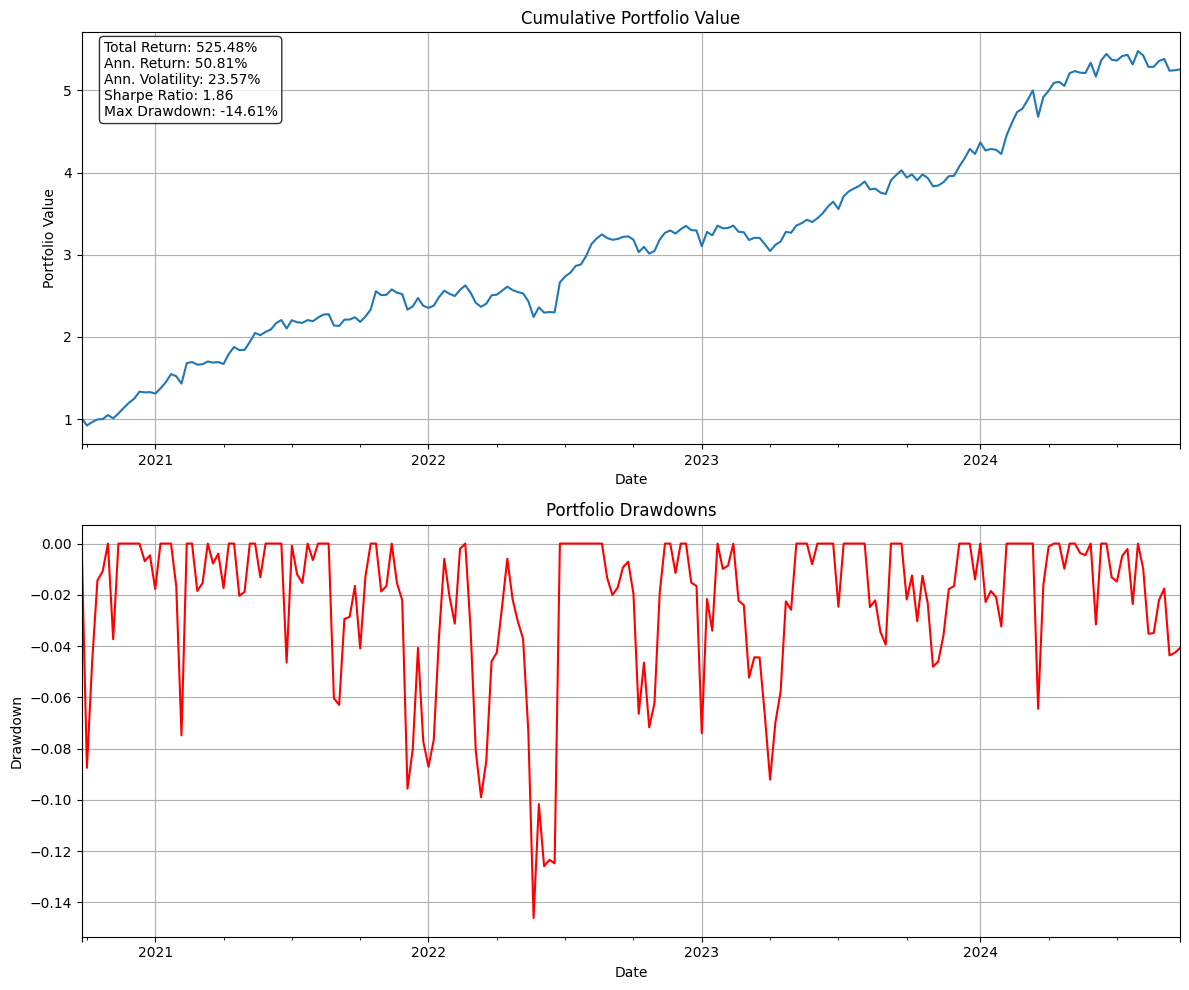

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def calculate_weekly_returns(df):
    if isinstance(df, pd.Series):
        df = df.to_frame()
    weekly_returns = df.resample('W').last().pct_change().shift(1).dropna()
    return weekly_returns

def rank_stocks(weekly_returns, window=50):
    if isinstance(weekly_returns, pd.Series):
        return [weekly_returns.name]
    avg_returns = weekly_returns.shift(1).rolling(window=window).mean()
    latest_avg_returns = avg_returns.iloc[-1].sort_values(ascending=False)
    return latest_avg_returns.index.tolist()

def get_top_stocks(ranked_stocks, n=20):
    return ranked_stocks[:min(n, len(ranked_stocks))]

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def create_min_variance_portfolio(returns, lambd=0.005, w0=None):
    if isinstance(returns, pd.Series):
        return np.array([1.0])

    n = len(returns.columns)
    init_guess = np.array([1/n for _ in range(n)])
    bounds = tuple((0, 1) for _ in range(n))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    cov_matrix = returns.cov()

    def obj_func(w):
        penalty = lambd * np.sum(np.abs(w - w0)) if w0 is not None else 0
        return portfolio_variance(w, cov_matrix) + penalty

    try:
        result = minimize(obj_func, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
        if result.success:
            return result.x
        else:
            return init_guess
    except:
        return init_guess

def denoise_covariance(cov_matrix, tn_relation):
    try:
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        eigenvalues = np.maximum(eigenvalues, 0)
        q = len(cov_matrix) / tn_relation
        max_eigenvalue = (1 + np.sqrt(1 / q))**2
        denoised_eigenvalues = np.where(eigenvalues > max_eigenvalue, eigenvalues, 0)
        denoised_cov_matrix = np.dot(eigenvectors, np.dot(np.diag(denoised_eigenvalues), eigenvectors.T))

        # Ensure the matrix is symmetric
        denoised_cov_matrix = (denoised_cov_matrix + denoised_cov_matrix.T) / 2

        return denoised_cov_matrix
    except Exception as e:
        print(f"Warning in denoise_covariance: {str(e)}")
        return cov_matrix

def nested_clustering_optimization(cov_matrix, n_clusters):
    if len(cov_matrix) == 1:
        return cov_matrix, np.array([1.0])

    # Create distance matrix
    dist_matrix = np.sqrt(2 * (1 - cov_matrix))

    # Standardize and add small noise to help with clustering
    scaler = StandardScaler()
    scaled_dist_matrix = scaler.fit_transform(dist_matrix)

    # Add small random noise to break ties and avoid duplicate points
    np.random.seed(42)  # for reproducibility
    scaled_dist_matrix += np.random.normal(0, 0.0001, scaled_dist_matrix.shape)

    # Determine optimal number of clusters using silhouette score
    max_clusters = min(n_clusters, len(cov_matrix) - 1)
    best_score = -1
    best_n_clusters = 2
    best_clusters = None

    for n in range(2, max_clusters + 1):
        try:
            kmeans = KMeans(n_clusters=n, n_init=20, max_iter=300)
            clusters = kmeans.fit_predict(scaled_dist_matrix)

            if len(np.unique(clusters)) < n:
                continue

            score = silhouette_score(scaled_dist_matrix, clusters)

            if score > best_score:
                best_score = score
                best_n_clusters = n
                best_clusters = clusters
        except:
            continue

    # If clustering failed, use hierarchical clustering as fallback
    if best_clusters is None or len(np.unique(best_clusters)) < 2:
        try:
            clustering = AgglomerativeClustering(n_clusters=2)
            best_clusters = clustering.fit_predict(scaled_dist_matrix)
            best_n_clusters = 2
            print("Switched to hierarchical clustering with 2 clusters")
        except:
            print(f"Using {len(cov_matrix)} equal weights as clustering failed")
            return cov_matrix, np.array([1.0/len(cov_matrix)] * len(cov_matrix))

    clustered_cov_matrix = np.zeros_like(cov_matrix)
    cluster_weights = np.zeros(best_n_clusters)

    # Calculate cluster weights using inverse variance
    for cluster in range(best_n_clusters):
        indices = np.where(best_clusters == cluster)[0]
        if len(indices) > 0:
            cluster_cov_matrix = cov_matrix[np.ix_(indices, indices)]

            # Use robust variance estimation
            cluster_var = max(np.trace(cluster_cov_matrix), 1e-8)
            cluster_weights[cluster] = 1.0 / cluster_var

    # Normalize cluster weights
    total_weight = np.sum(cluster_weights)
    if total_weight > 0:
        cluster_weights = cluster_weights / total_weight
    else:
        cluster_weights = np.array([1.0/best_n_clusters] * best_n_clusters)

    return clustered_cov_matrix, cluster_weights

def minimize_variance_within_clusters(clustered_cov_matrix, cluster_weights, returns):
    if isinstance(returns, pd.Series):
        return np.array([1.0])

    n_assets = len(returns.columns)
    final_weights = np.zeros(n_assets)

    try:
        for cluster in range(len(cluster_weights)):
            if cluster_weights[cluster] > 0:
                cluster_return = returns.iloc[:, [cluster]]
                try:
                    weights = create_min_variance_portfolio(cluster_return)
                    final_weights[cluster] = weights * cluster_weights[cluster]
                except:
                    final_weights[cluster] = cluster_weights[cluster]
    except Exception as e:
        print(f"Warning: Error in minimize_variance_within_clusters: {str(e)}")
        final_weights = np.array([1.0/n_assets] * n_assets)

    weight_sum = np.sum(final_weights)
    if weight_sum > 0:
        final_weights = final_weights / weight_sum
    else:
        final_weights = np.array([1.0/n_assets] * n_assets)

    return final_weights

def get_stock_weightage_nco(weekly_returns, current_date, n_clusters, tn_relation):
    try:
        # Use data up to previous week to avoid look-ahead bias
        data_slice = weekly_returns.loc[:current_date].iloc[:-1][-50:]

        if len(data_slice) < 50:
            raise ValueError("Not enough historical data before the target date.")

        if isinstance(data_slice, pd.Series):
            return {data_slice.name: 1.0}

        ranked_stocks = rank_stocks(data_slice)
        top_stocks = get_top_stocks(ranked_stocks)
        top_stock_returns = data_slice[top_stocks]

        if len(top_stocks) == 1:
            return {top_stocks[0]: 1.0}

        # Calculate correlation matrix for clustering
        corr_matrix = top_stock_returns.corr()
        corr_matrix = corr_matrix.fillna(0)
        corr_matrix = (corr_matrix + corr_matrix.T) / 2

        # Ensure matrix is positive semi-definite
        min_eigenvalue = np.min(np.linalg.eigvals(corr_matrix))
        if min_eigenvalue < 0:
            corr_matrix -= 1.1 * min_eigenvalue * np.eye(len(corr_matrix))

        # Calculate covariance matrix for portfolio optimization
        cov_matrix = top_stock_returns.cov()

        # Ensure covariance matrix is positive definite
        min_eigenvalue = np.min(np.linalg.eigvals(cov_matrix))
        if min_eigenvalue < 0:
            cov_matrix -= 1.1 * min_eigenvalue * np.eye(len(cov_matrix))

        denoised_cov_matrix = denoise_covariance(cov_matrix, tn_relation)
        clustered_cov_matrix, cluster_weights = nested_clustering_optimization(denoised_cov_matrix, n_clusters)
        final_weights = minimize_variance_within_clusters(clustered_cov_matrix, cluster_weights, top_stock_returns)

        final_weights = np.maximum(final_weights, 0)
        final_weights = final_weights / np.sum(final_weights)

        stock_weights = dict(zip(top_stocks, final_weights))
        return stock_weights

    except Exception as e:
        print(f"Warning in get_stock_weightage_nco: {str(e)}")
        equal_weight = 1.0 / len(weekly_returns.columns)
        return dict(zip(weekly_returns.columns, [equal_weight] * len(weekly_returns.columns)))

def nco_backtest_strategy(df, n_clusters=5, tn_relation=1):
    weekly_returns = calculate_weekly_returns(df)
    portfolio_returns = []
    weightage_history = []

    for i in range(50, len(weekly_returns)):
        current_date = weekly_returns.index[i - 1]
        next_week = weekly_returns.index[i]

        try:
            weightage = get_stock_weightage_nco(weekly_returns.iloc[:i], current_date, n_clusters, tn_relation)
            top_stocks = list(weightage.keys())
            weights = list(weightage.values())

            next_week_return = weekly_returns.loc[next_week][top_stocks].dot(weights)
            portfolio_returns.append(next_week_return)
            weightage_history.append((next_week, weightage))

        except Exception as e:
            print(f"Warning: Error in week {next_week}: {str(e)}")
            continue

    valid_index = weekly_returns.index[50:50+len(portfolio_returns)]
    return pd.Series(portfolio_returns, index=valid_index), weightage_history

def calculate_performance_metrics(portfolio_returns):
    cumulative_returns = (1 + portfolio_returns).cumprod()
    total_return = cumulative_returns.iloc[-1]
    annualized_return = (total_return ** (52 / len(cumulative_returns)) - 1)
    annualized_volatility = portfolio_returns.std() * np.sqrt(52)
    sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(52)

    drawdowns = cumulative_returns / cumulative_returns.cummax() - 1
    max_drawdown = drawdowns.min()

    return {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_volatility,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown
    }

def plot_portfolio_performance(portfolio_returns):
    metrics = calculate_performance_metrics(portfolio_returns)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot cumulative returns
    cumulative_returns = (1 + portfolio_returns).cumprod()
    cumulative_returns.plot(ax=ax1)
    ax1.set_title('Cumulative Portfolio Value')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Portfolio Value')
    ax1.grid(True)

    # Add metrics as text
    metrics_text = (
        f"Total Return: {metrics['total_return']:.2%}\n"
        f"Ann. Return: {metrics['annualized_return']:.2%}\n"
        f"Ann. Volatility: {metrics['annualized_volatility']:.2%}\n"
        f"Sharpe Ratio: {metrics['sharpe_ratio']:.2f}\n"
        f"Max Drawdown: {metrics['max_drawdown']:.2%}"
    )
    ax1.text(0.02, 0.98, metrics_text,
             transform=ax1.transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Plot drawdowns
    drawdowns = cumulative_returns / cumulative_returns.cummax() - 1
    drawdowns.plot(ax=ax2, color='red')
    ax2.set_title('Portfolio Drawdowns')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Drawdown')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Example usage
    df = pd.read_csv('total_df.csv', index_col='Date', parse_dates=True)

    # Run the backtest
    portfolio_returns, weightage_history = nco_backtest_strategy(df, n_clusters=5, tn_relation=1)

    # Plot results
    plot_portfolio_performance(portfolio_returns)

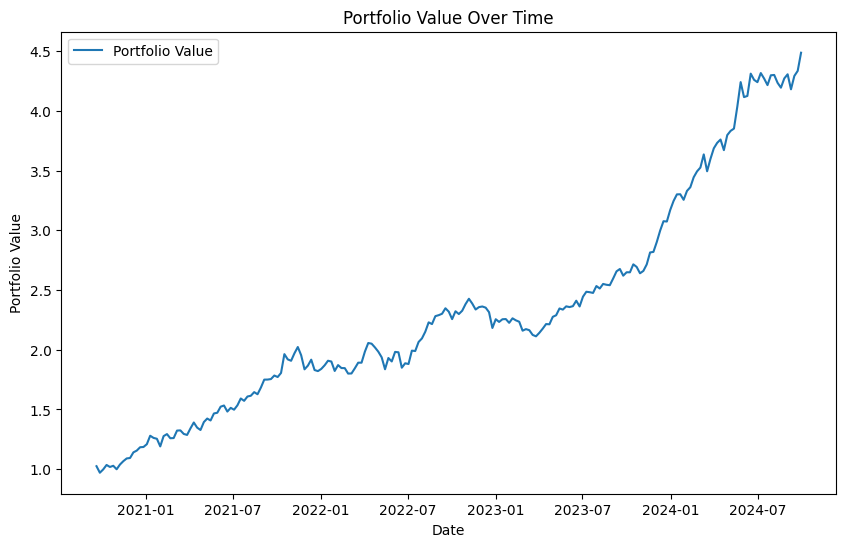

Backtest Results:
Total Return: 1.5709
Annualized Return: 0.4706
Annualized Volatility: 0.1788
Sharpe Ratio: 2.5207
Sortino Ratio: 4.0450
Max Drawdown: -0.1348
Calmar Ratio: 3.4910


In [ ]:
import matplotlib.pyplot as plt

def calculate_portfolio_value(portfolio_returns, initial_capital=1.0):
    # Calculate cumulative returns to represent portfolio value over time
    portfolio_value = (1 + portfolio_returns).cumprod() * initial_capital
    return portfolio_value

def calculate_metrics(portfolio_returns, risk_free_rate=0.02):
    total_return = portfolio_returns.sum()
    annualized_return = (1 + portfolio_returns.mean()) ** 52 - 1
    annualized_volatility = portfolio_returns.std() * np.sqrt(52)
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    sortino_ratio = (annualized_return - risk_free_rate) / (portfolio_returns[portfolio_returns < 0].std() * np.sqrt(52))
    max_drawdown = np.min(portfolio_returns.cumsum() - np.maximum.accumulate(portfolio_returns.cumsum()))
    calmar_ratio = annualized_return / abs(max_drawdown)

    metrics = {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Max Drawdown': max_drawdown,
        'Calmar Ratio': calmar_ratio
    }

    return metrics

def plot_portfolio_value(portfolio_returns, initial_capital=1.0):
    portfolio_value = calculate_portfolio_value(portfolio_returns, initial_capital)

    plt.figure(figsize=(10, 6))
    plt.plot(portfolio_value, label='Portfolio Value')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.show()

# Backtest results and plotting
portfolio_returns, weightage_history = backtest_strategy(df)

# Plot the portfolio value over time
plot_portfolio_value(portfolio_returns)

# Calculate and display the metrics
metrics = calculate_metrics(portfolio_returns)
print("Backtest Results:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")



In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def calculate_weekly_returns(df):
    weekly_data = df.resample('W').last()
    weekly_returns = weekly_data.pct_change().dropna()
    return weekly_returns

def rank_stocks(weekly_returns, window=50):
    avg_returns = weekly_returns.rolling(window=window).mean()
    latest_avg_returns = avg_returns.iloc[-1].sort_values(ascending=False)
    return latest_avg_returns.index.tolist()

def get_top_stocks(ranked_stocks, n=20):
    return ranked_stocks[:n]

def marcenko_pastur_pdf(x, Q, sigma=1):
    """Calculate Marcenko-Pastur probability density at x"""
    y = 1/Q
    b = np.power(sigma * (1 + np.sqrt(1/Q)), 2)  # Upper bound
    a = np.power(sigma * (1 - np.sqrt(1/Q)), 2)  # Lower bound

    return (Q/(2*np.pi*sigma*sigma*x)) * np.sqrt((b-x)*(x-a)) if a <= x <= b else 0

def find_eigenvalue_cutoff(eigenvalues, N, T):
    """
    Find the eigenvalue cutoff point using Marcenko-Pastur distribution
    N: number of assets
    T: number of observations
    """
    Q = N/T
    sigma = np.std(eigenvalues)

    # Calculate theoretical distribution
    x = np.linspace(0, max(eigenvalues), 1000)
    mp_density = [marcenko_pastur_pdf(xi, Q, sigma) for xi in x]

    # Calculate empirical distribution
    kde = gaussian_kde(eigenvalues)
    empirical_density = kde(x)

    # Find intersection point
    diff = empirical_density - mp_density
    cutoff_idx = np.where(diff > 0)[0][0]
    return x[cutoff_idx]

def denoise_correlation_matrix(returns):
    """
    Implement the de-noising algorithm using eigenvalue adjustment
    """
    # Calculate sample covariance matrix
    cov_matrix = returns.cov().values
    correlation_matrix = returns.corr().values

    # Perform eigendecomposition
    eigenvalues, eigenvectors = np.linalg.eigh(correlation_matrix)
    eigenvalues = eigenvalues[::-1]
    eigenvectors = eigenvectors[:, ::-1]

    # Find cutoff eigenvalue
    N = len(returns.columns)
    T = len(returns)
    lambda_plus = find_eigenvalue_cutoff(eigenvalues, N, T)

    # Find position i where eigenvalues become noise
    i = np.where(eigenvalues <= lambda_plus)[0][0]

    # Adjust noisy eigenvalues
    adjusted_eigenvalues = eigenvalues.copy()
    for j in range(i, N):
        adjusted_eigenvalues[j] = np.mean(eigenvalues[i:])

    # Reconstruct correlation matrix
    Lambda_tilde = np.diag(adjusted_eigenvalues)
    C_tilde = eigenvectors @ Lambda_tilde @ eigenvectors.T

    # Rescale to ensure diagonal entries are 1
    scale = np.sqrt(np.diag(C_tilde))
    C = C_tilde / (scale[:, None] @ scale[None, :])

    # Convert back to covariance matrix
    std_dev = np.sqrt(np.diag(cov_matrix))
    denoised_cov = C * (std_dev[:, None] @ std_dev[None, :])

    return denoised_cov

def create_min_variance_portfolio(returns, prev_weights=None, lambda_cost=0.0050):
    """
    Create a minimum variance portfolio with transaction costs and de-noised covariance matrix
    """
    n = len(returns.columns)

    # Calculate de-noised covariance matrix
    cov_matrix = denoise_correlation_matrix(returns)

    # If no previous weights provided, initialize with zeros
    if prev_weights is None:
        prev_weights = np.zeros(n)

    def portfolio_objective(weights, cov_matrix, prev_weights, lambda_cost):
        variance = np.dot(weights.T, np.dot(cov_matrix, weights))
        if prev_weights is not None:
            transaction_costs = lambda_cost * np.sum(np.abs(weights - prev_weights))
        else:
            transaction_costs = 0
        return variance + transaction_costs

    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    ]

    bounds = tuple((0, 1) for _ in range(n))
    x0 = prev_weights if prev_weights is not None else np.array([1/n] * n)

    result = minimize(
        portfolio_objective,
        x0,
        args=(cov_matrix, prev_weights, lambda_cost),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'ftol': 1e-9, 'maxiter': 1000}
    )

    if not result.success:
        print(f"Warning: Optimization failed: {result.message}")

    return result.x

def get_stock_weightage(weekly_returns, current_date, prev_weights=None):
    data_slice = weekly_returns.loc[:current_date].iloc[-50:]

    if len(data_slice) < 50:
        raise ValueError("Not enough historical data before the target date.")

    ranked_stocks = rank_stocks(data_slice)
    top_stocks = get_top_stocks(ranked_stocks)
    top_stock_returns = data_slice[top_stocks]

    # Align previous weights with current stock selection
    if prev_weights is not None:
        aligned_prev_weights = np.zeros(len(top_stocks))
        for i, stock in enumerate(top_stocks):
            if stock in prev_weights:
                aligned_prev_weights[i] = prev_weights[stock]
        prev_weights = aligned_prev_weights

    # Get optimal weights
    weights = create_min_variance_portfolio(
        top_stock_returns,
        prev_weights,
        lambda_cost=0.0050  # 50 basis points transaction cost
    )

    # Create dictionary of stock weights
    stock_weights = dict(zip(top_stocks, weights))

    # Ensure weights sum to 1 (handle numerical precision issues)
    weight_sum = sum(stock_weights.values())
    if abs(weight_sum - 1.0) > 1e-5:
        for stock in stock_weights:
            stock_weights[stock] /= weight_sum

    # Debug information
    weight_values = list(stock_weights.values())
    print(f"\nDate: {current_date}")
    print(f"Weight standard deviation: {np.std(weight_values):.4f}")
    print(f"Max weight: {max(weight_values):.4f}")
    print(f"Min weight: {min(weight_values):.4f}")

    return stock_weights

def calculate_drawdown(cumulative_returns):
    drawdown = cumulative_returns / cumulative_returns.cummax() - 1
    max_drawdown = drawdown.min()
    return drawdown, max_drawdown

def sortino_ratio(returns, target=0, periods_per_year=52):
    downside_returns = returns[returns < target]
    downside_deviation = np.sqrt((downside_returns ** 2).mean()) * np.sqrt(periods_per_year)
    annualized_return = returns.mean() * periods_per_year
    return annualized_return / downside_deviation if downside_deviation != 0 else np.nan

def calmar_ratio(annualized_return, max_drawdown):
    return annualized_return / abs(max_drawdown) if max_drawdown != 0 else np.nan

def backtest_strategy(df):
    weekly_returns = calculate_weekly_returns(df)
    portfolio_returns = []
    weightage_history = []
    prev_weights = None

    for i in range(50, len(weekly_returns)):
        current_date = weekly_returns.index[i-1]
        next_week = weekly_returns.index[i]

        try:
            weightage = get_stock_weightage(weekly_returns.iloc[:i], current_date, prev_weights)
            top_stocks = list(weightage.keys())
            weights = list(weightage.values())

            # Calculate transaction costs
            if prev_weights is not None:
                transaction_costs = 0.0050 * sum(  # 50 basis points
                    abs(weightage.get(stock, 0) - prev_weights.get(stock, 0))
                    for stock in set(weightage.keys()) | set(prev_weights.keys())
                )
            else:
                transaction_costs = 0

            # Calculate returns after transaction costs
            next_week_return = weekly_returns.loc[next_week][top_stocks].dot(weights) - transaction_costs
            portfolio_returns.append(next_week_return)
            weightage_history.append((next_week, weightage))

            prev_weights = weightage

        except ValueError as e:
            print(f"Skipping week {next_week} due to error: {e}")

    valid_index = weekly_returns.index[50:50+len(portfolio_returns)]
    return pd.Series(portfolio_returns, index=valid_index), weightage_history

def analyze_and_plot_results(portfolio_returns, weightage_history):
    # Calculate cumulative returns and metrics
    cumulative_returns = (1 + portfolio_returns).cumprod()
    total_return = cumulative_returns.iloc[-1]
    profit_only_return = total_return - 1
    annualized_return = (total_return ** (52/len(cumulative_returns)) - 1)
    annualized_volatility = portfolio_returns.std() * np.sqrt(52)
    sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(52)

    # Calculate drawdown and additional metrics
    drawdown, max_drawdown = calculate_drawdown(cumulative_returns)
    calmar = calmar_ratio(annualized_return, max_drawdown)
    sortino = sortino_ratio(portfolio_returns)

    # Print backtest results
    print("\nBacktest Results:")
    print(f"Total Return (including initial capital): {total_return:.4f}")
    print(f"This means for every $1 invested, you now have ${total_return:.2f}")
    print(f"Profit-only Return: {profit_only_return:.4%}")
    print(f"Annualized Return: {annualized_return:.2%}")
    print(f"Annualized Volatility: {annualized_volatility:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Sortino Ratio: {sortino:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2%}")
    print(f"Calmar Ratio: {calmar:.2f}")

    # Plot cumulative returns and drawdown
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    cumulative_returns.plot()
    plt.title('Cumulative Portfolio Value (Starting from $1)')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    drawdown.plot(color='red')
    plt.title('Drawdown Over Time')
    plt.xlabel('Date')
    plt.ylabel('Drawdown')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Plot weight evolution
    dates = [x[0] for x in weightage_history]
    all_stocks = set()
    for _, weights in weightage_history:
        all_stocks.update(weights.keys())

    weight_df = pd.DataFrame(index=dates, columns=list(all_stocks), dtype=float)

    for date, weights in weightage_history:
        for stock in all_stocks:
            weight_df.loc[date, stock] = weights.get(stock, 0)

    plt.figure(figsize=(12, 6))
    weight_df.plot.area(stacked=True)
    plt.title('Portfolio Weights Evolution Over Time')
    plt.xlabel('Date')
    plt.ylabel('Weight')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    return {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_volatility,
        'sharpe_ratio': sharpe_ratio,
        'sortino_ratio': sortino,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar
    }

def main():
    # Load the data
    print("Loading data...")
    df = pd.read_csv('total_df.csv', index_col='Date', parse_dates=True)

    # Run backtest
    print("\nRunning backtest with de-noised covariance matrices...")
    portfolio_returns, weightage_history = backtest_strategy(df)

    # Analyze and plot results
    print("\nAnalyzing results...")
    metrics = analyze_and_plot_results(portfolio_returns, weightage_history)

    # Get weightage for the last date in the dataset
    last_date = df.index[-1]
    try:
        print("\nCalculating final portfolio weights...")
        weightage = get_stock_weightage(calculate_weekly_returns(df), last_date)
        print(f"\nStock weightage for week of {last_date.date()}:")
        for stock, weight in sorted(weightage.items(), key=lambda x: x[1], reverse=True):
            print(f"{stock}: {weight:.4f}")
    except ValueError as e:
        print(f"Error: {e}")